# **Exploración y reconstrucción del Data Set - rcc_train**

In [ ]:
#Importar las librerias necesarias para el proyecto
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import re
from google.colab import files

In [ ]:
#Obtener los datos del archivo del historíal de crediticio
ruta_train = '/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/rcc_train.csv'
df_train = pd.read_csv(ruta_train)

In [ ]:
#Contar la cantidad de filas y columnas
df_train.shape

(30391626, 9)

In [ ]:
#Obtener información del set de datos
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30391626 entries, 0 to 30391625
Data columns (total 9 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   codmes                    int64  
 1   key_value                 int64  
 2   condicion                 int64  
 3   tipo_credito              int64  
 4   cod_instit_financiera     int64  
 5   saldo                     float64
 6   PRODUCTO                  int64  
 7   RIESGO_DIRECTO            int64  
 8   COD_CLASIFICACION_DEUDOR  int64  
dtypes: float64(1), int64(8)
memory usage: 2.0 GB


In [ ]:
#Desplegar información de un cliente cliente
df_train[(df_train.key_value == 4)].sort_values("codmes")

,codmes,key_value,condicion,tipo_credito,cod_instit_financiera,saldo,PRODUCTO,RIESGO_DIRECTO,COD_CLASIFICACION_DEUDOR
367010,201707,4,0,12,61,-0.052054,5,-1,0
367009,201707,4,0,12,61,-0.052244,0,1,0
367008,201707,4,0,12,61,-0.068906,7,-1,0
1092888,201708,4,0,12,61,-0.054126,0,1,0
1092890,201708,4,0,12,61,-0.052054,5,-1,0
1092889,201708,4,0,12,61,-0.068906,7,-1,0
67435,201709,4,0,12,61,-0.068906,7,-1,0
67436,201709,4,0,12,61,-0.056007,0,1,0
67437,201709,4,0,12,61,-0.052054,5,-1,0
372618,201710,4,0,12,33,-0.072590,6,-1,0


In [ ]:
df_train['key_value'].nunique()

358487

In [ ]:
#Identificar los valores únicos de cada atributo del set de datos
print('tipo_credito', df_train['tipo_credito'].unique())
print('PRODUCTO', df_train['PRODUCTO'].unique())
print('RIESGO_DIRECTO', df_train['RIESGO_DIRECTO'].unique())
print('COD_CLASIFICACION_DEUDOR', df_train['COD_CLASIFICACION_DEUDOR'].unique())
print('tipo_credito', df_train['tipo_credito'].unique())
print('codmes', df_train['codmes'].unique())
print('condicion', df_train['condicion'].unique())
print('cod_instit_financiera', df_train['cod_instit_financiera'].unique())
print('Cantidad de saldos diferentes', df_train['saldo'].nunique())


tipo_credito [12 11  9 10 99 13  8  6]
PRODUCTO [  6   7   5   8   0   2   3   1 255   9  10   4  11  13  14  15  16  12
  18  17  19  20  21  22  29  30  25  31  28  23  24  32  27  34  39  38
  36  33  37  35  40  41]
RIESGO_DIRECTO [-1  1  2  3  5]
COD_CLASIFICACION_DEUDOR [0 1 5 3 4 2]
tipo_credito [12 11  9 10 99 13  8  6]
codmes [201711 201710 201708 201705 201802 201709 201707 201703 201704 201706
 201801 201712]
condicion [   0    6    1 ... 7718 7343 8126]
cod_instit_financiera [ 33  61  32  15  38   8   1  20  37  11  10   0  13  34  25  57  28  55
  18  19  17  64   3   2  59  43  65  46  29  60  63  36  62  41  30  90
  42  45  40  54  95  24  44  56   7  22  16  23  35  27  48  53  21   4
  49  82  69  96  77 106 104  92  58  94  51  39  85 101 105  12 108  86
 100 107  66  52 102  99  88  83 103  50  91  80  79  93  26  68  73  75
  78   9   6   5  81  70  14  47  97  76  89  98  67  74  71  31  84  72
  87]
Cantidad de saldos diferentes 190285


In [ ]:
## Discretizar la columna "condicion"
bins = [-1, 0, 10, 20,30, 60, 90, 180, 360, 720, float("inf")]
df_train['condicion'] = pd.cut(df_train['condicion'], bins)
df_train['condicion'] = df_train['condicion'].cat.codes

In [ ]:
#Visualizar la nueva codificación de condición
print('condicion', df_train['condicion'].unique())

condicion [0 1 8 9 7 4 5 2 6 3]


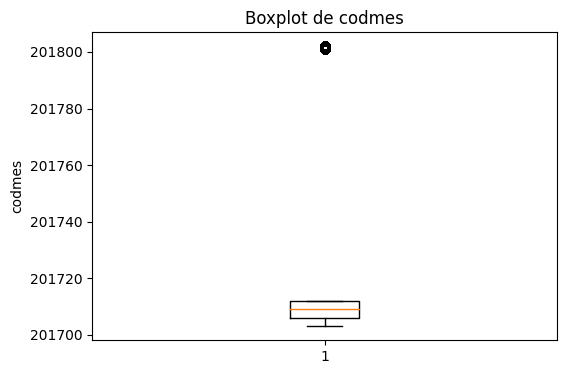

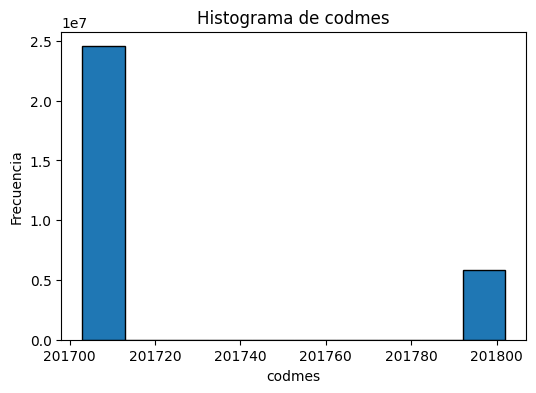

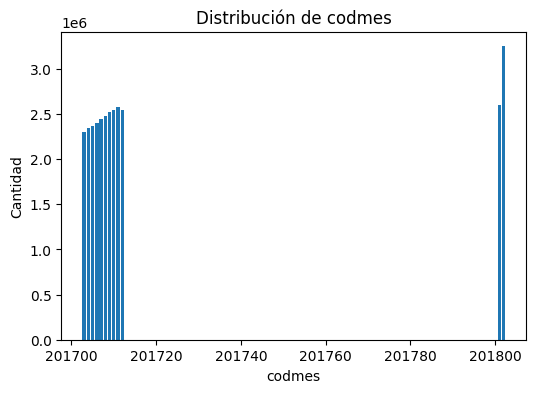

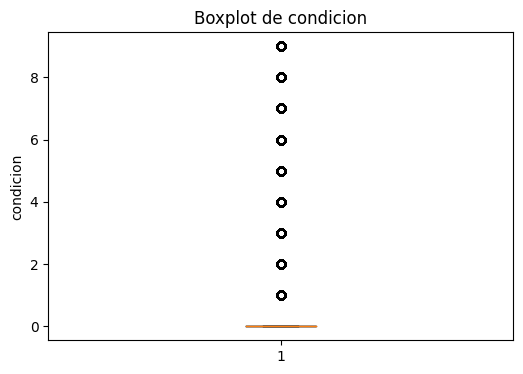

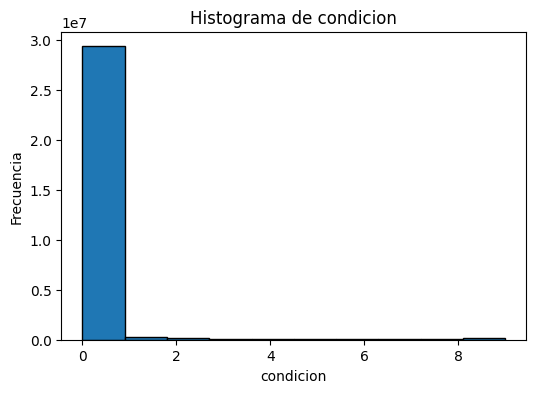

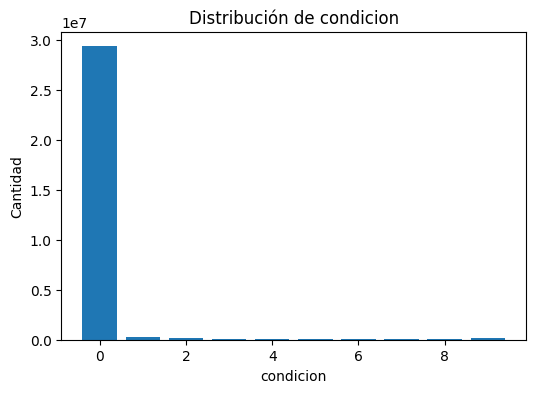

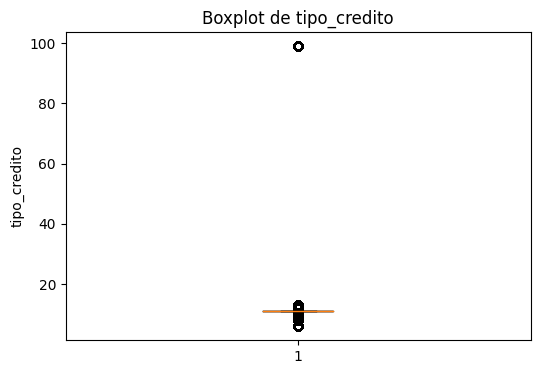

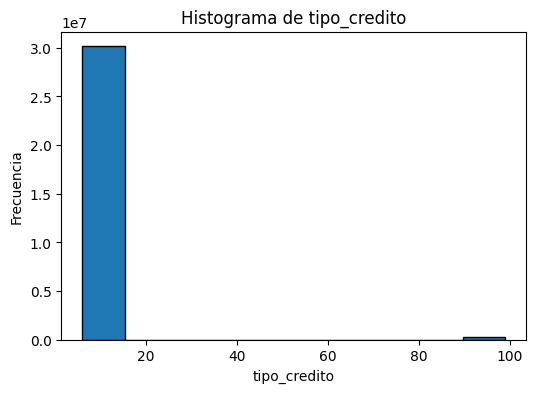

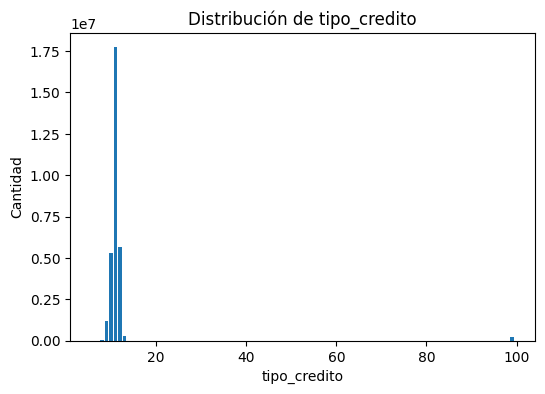

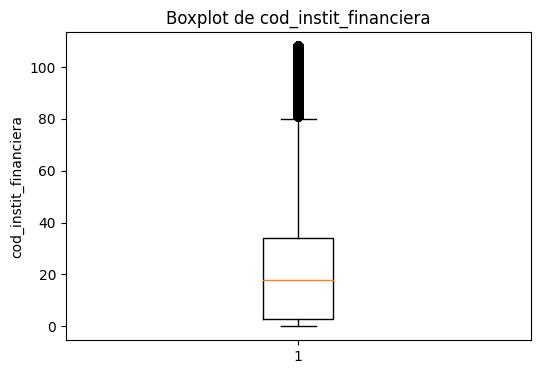

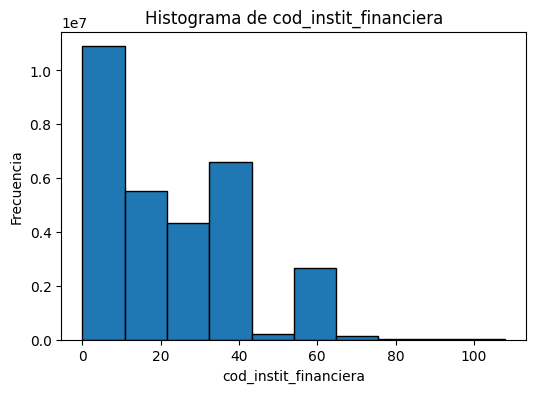

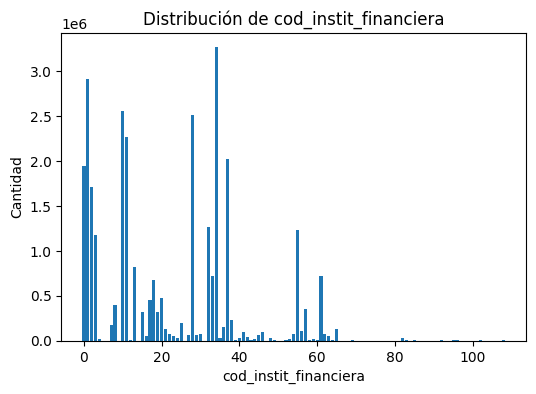

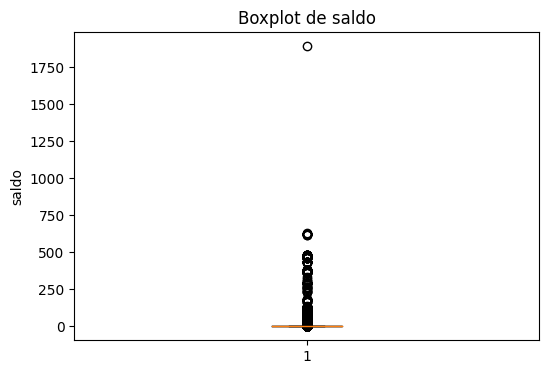

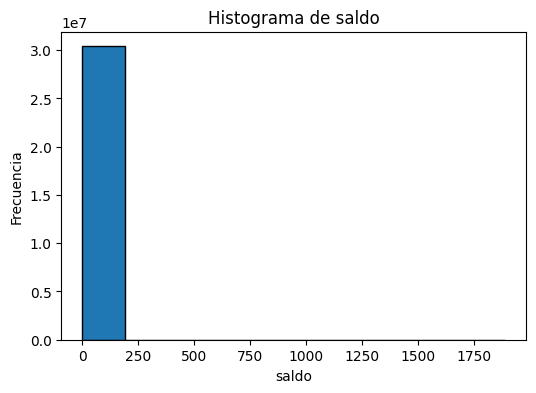

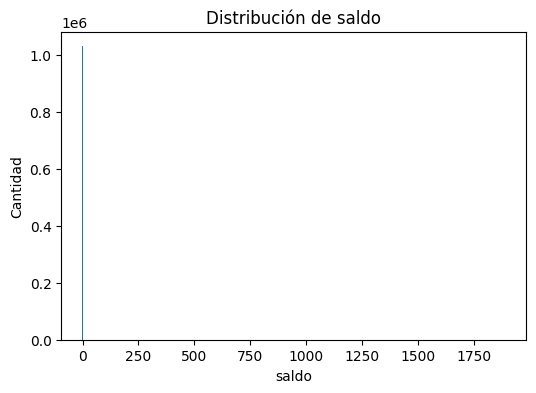

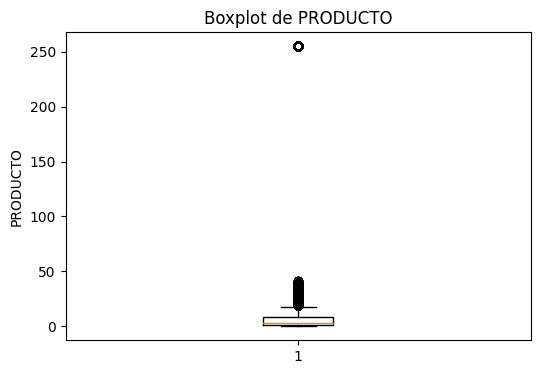

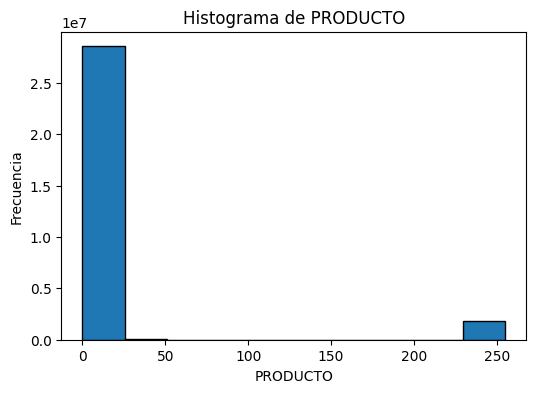

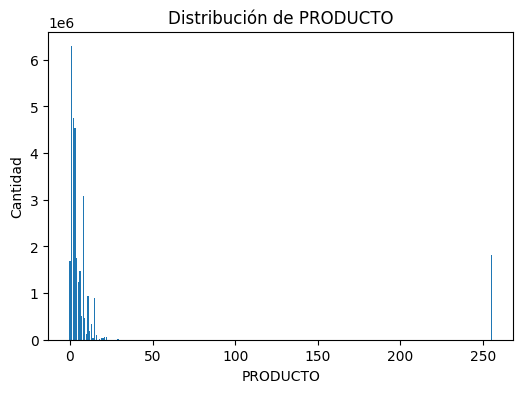

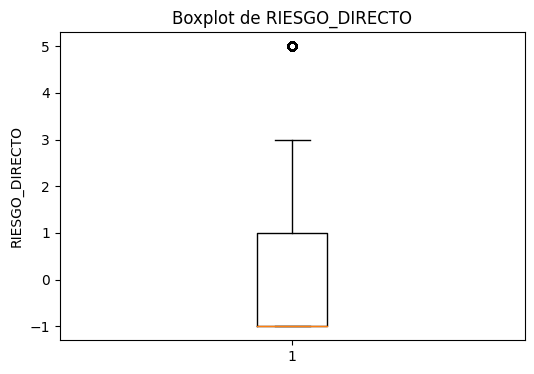

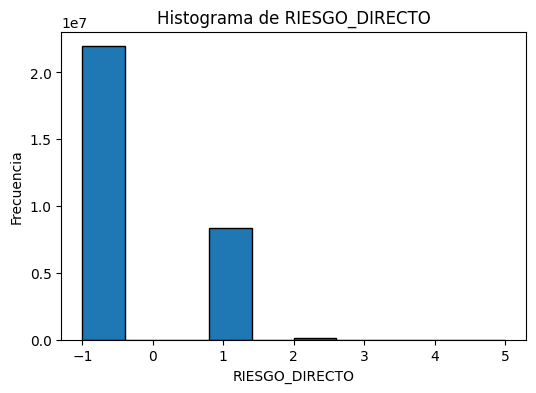

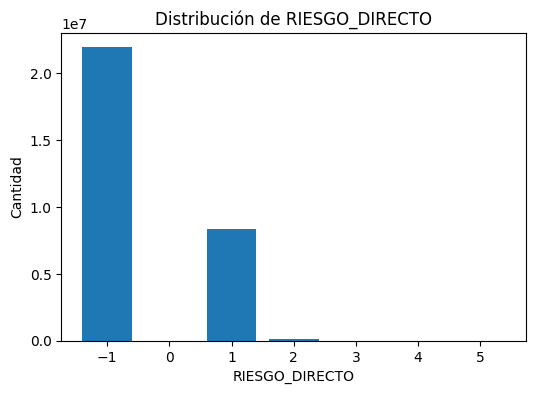

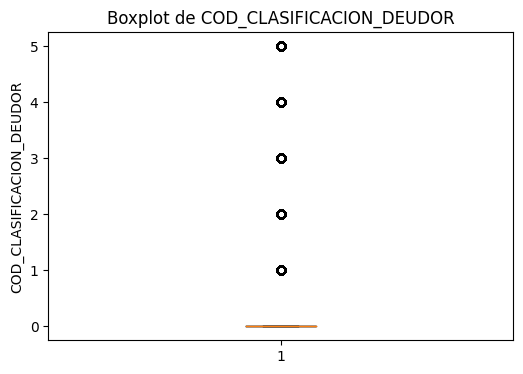

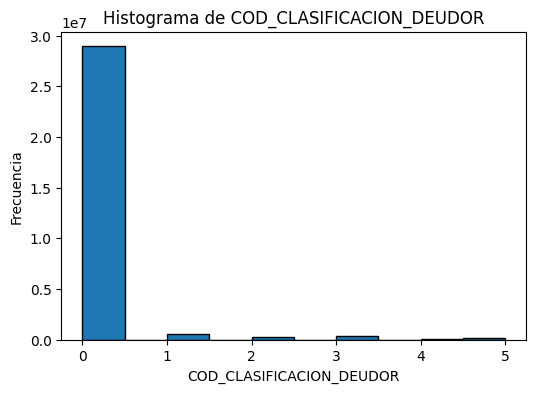

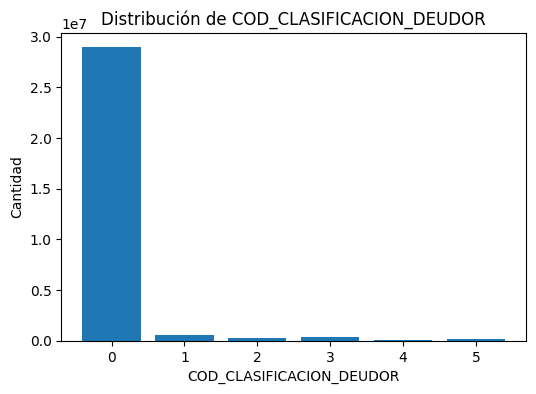

In [ ]:
#Graficar cada columna cuantitativa del set de datos, para tratar los valores
#atípicos
import matplotlib.pyplot as plt
for column in df_train.columns:
  if column != 'key_value':
      plt.figure(figsize=(6, 4))
      plt.title(f"Boxplot de {column}")
      plt.boxplot(df_train[column])
      plt.ylabel(column)
      plt.show()

      plt.figure(figsize=(6, 4))
      plt.hist(df_train[column], bins=10, edgecolor='k')
      plt.xlabel(column)
      plt.ylabel('Frecuencia')
      plt.title(f'Histograma de {column}')
      plt.show()

      plt.figure(figsize=(6, 4))
      cant_col = df_train.groupby(column).size().reset_index(name='count')
      plt.bar(cant_col[column], cant_col['count'])
      plt.xlabel(f'{column}')
      plt.ylabel('Cantidad')
      plt.title(f'Distribución de {column}')
      plt.show()

In [ ]:
import pandas as pd

# Cargar el archivo de historial crediticio en df_train (reemplaza esta línea con la carga de tus datos)
# df_train = pd.read_csv('ruta_del_archivo.csv')

# Conservamos un único registro por cliente en las columnas tipo_credito, RIESGO_DIRECTO y COD_CLASIFICACION_DEUDOR
#unique_records_df = df_train.drop_duplicates(subset=['key_value', 'tipo_credito', 'RIESGO_DIRECTO', 'COD_CLASIFICACION_DEUDOR'])

# Aplicamos codificación one-hot a la columna 'tipo_credito'
df_encoded = pd.get_dummies(df_train, columns=['tipo_credito'], prefix='tipo_credito')

# Aplicamos codificación one-hot a las columnas 'RIESGO_DIRECTO' y 'COD_CLASIFICACION_DEUDOR'
df_encoded = pd.get_dummies(df_encoded, columns=['RIESGO_DIRECTO', 'COD_CLASIFICACION_DEUDOR'],
                            prefix=['riesgo_direct', 'clasificacion_deudor'])

# Calculamos la cantidad única de instituciones financieras por cliente
instituciones_por_cliente = df_train.groupby('key_value')['cod_instit_financiera'].nunique().reset_index()
instituciones_por_cliente.rename(columns={'cod_instit_financiera': 'cant_inst_financieras'}, inplace=True)

# Calcular la moda de la variable 'PRODUCTO' por cliente
moda_producto_por_cliente = df_encoded.groupby('key_value')['PRODUCTO'].apply(lambda x: x.mode()[0]).reset_index()
moda_producto_por_cliente.rename(columns={'PRODUCTO': 'moda_producto'}, inplace=True)

# Filtrar las filas donde la 'condicion' es diferente de cero
df_filtered = df_train[df_train['condicion'] != 0]

# Calcular la cantidad de meses únicos por 'key_value' donde la 'condicion' es diferente de cero
meses_con_condicion = df_filtered.groupby('key_value')['codmes'].nunique().reset_index()
meses_con_condicion.rename(columns={'codmes': 'cant_meses_condicion'}, inplace=True)


# Agrupamos los datos por 'key_value' y calculamos estadísticas agregadas
aggregated_df = df_encoded.groupby('key_value').agg({
    'codmes': 'nunique',
    'condicion': 'max',
    'saldo': 'mean',
    'PRODUCTO': 'nunique',
    # Agregar todas las columnas one-hot encodings generadas
    **{col: 'max' for col in df_encoded.columns if col.startswith('tipo_credito')},
    **{col: 'max' for col in df_encoded.columns if col.startswith('riesgo_direct')},
    **{col: 'max' for col in df_encoded.columns if col.startswith('clasificacion_deudor')},
}).reset_index()

# Combinamos el DataFrame de instituciones financieras con el DataFrame agregado
aggregated_df = pd.merge(aggregated_df, meses_con_condicion, on='key_value', how='outer')
aggregated_df = pd.merge(aggregated_df, moda_producto_por_cliente, on='key_value', how='outer')
aggregated_df = pd.merge(aggregated_df, instituciones_por_cliente, on='key_value', how='outer')

# Renombramos las columnas agregadas para mayor claridad
aggregated_df.rename(columns={
    'codmes': 'distinct_months',
    'condición': 'max_condición',
    'saldo': 'mean_saldo',
    'PRODUCTO': 'cant_productos',
    'moda_producto': 'moda_producto',
    'cant_meses_condicion': 'meses_condicion' #cantidad de meses en mora /condición
    # Renombrar más columnas según corresponda
}, inplace=True)
# Ver el nuevo DataFrame agregado
#print(aggregated_df.head())

KeyboardInterrupt: ignored

In [ ]:
#df_encoded['key_value'].nunique()
#df_filtered['key_value'].nunique()
aggregated_df['key_value'].nunique()

358487

In [ ]:
#df_train[(df_train.key_value == 4)]
#df_encoded[(df_encoded.key_value == 4)]
#aggregated_df[(aggregated_df.key_value == 4)]
#aggregated_df.groupby('producto').size().reset_index(name='count')

In [ ]:
aggregated_df.head()

,key_value,distinct_months,condicion,mean_saldo,cant_productos,tipo_credito_6,tipo_credito_8,tipo_credito_9,tipo_credito_10,tipo_credito_11,...,riesgo_direct_5,clasificacion_deudor_0,clasificacion_deudor_1,clasificacion_deudor_2,clasificacion_deudor_3,clasificacion_deudor_4,clasificacion_deudor_5,meses_condicion,moda_producto,cant_inst_financieras
0,0,12,0,-0.038714,6,0,0,0,0,1,...,0,1,0,0,0,0,0,NaN,2,2
1,1,3,0,-0.067530,3,0,0,0,1,0,...,0,1,0,0,0,0,0,NaN,4,2
2,2,2,0,-0.060516,3,0,0,0,1,0,...,0,1,0,0,0,0,0,NaN,1,1
3,3,2,0,0.027687,4,0,0,0,1,0,...,0,1,0,0,0,0,0,NaN,1,2
4,4,8,5,-0.062406,8,0,0,0,0,1,...,0,1,1,1,1,0,0,3.0,0,3


In [ ]:
for col in aggregated_df.columns:
  print(f'{col}',aggregated_df[col].nunique())

key_value 358487
distinct_months 12
condicion 10
mean_saldo 328868
cant_productos 17
tipo_credito_6 2
tipo_credito_8 2
tipo_credito_9 2
tipo_credito_10 2
tipo_credito_11 2
tipo_credito_12 2
tipo_credito_13 2
tipo_credito_99 2
riesgo_direct_-1 2
riesgo_direct_1 1
riesgo_direct_2 2
riesgo_direct_3 2
riesgo_direct_5 2
clasificacion_deudor_0 2
clasificacion_deudor_1 2
clasificacion_deudor_2 2
clasificacion_deudor_3 2
clasificacion_deudor_4 2
clasificacion_deudor_5 2
meses_condicion 12
moda_producto 31
cant_inst_financieras 14


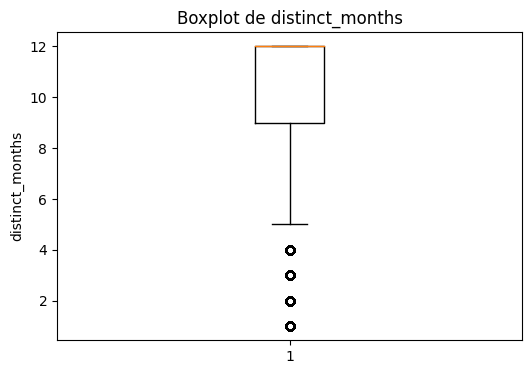

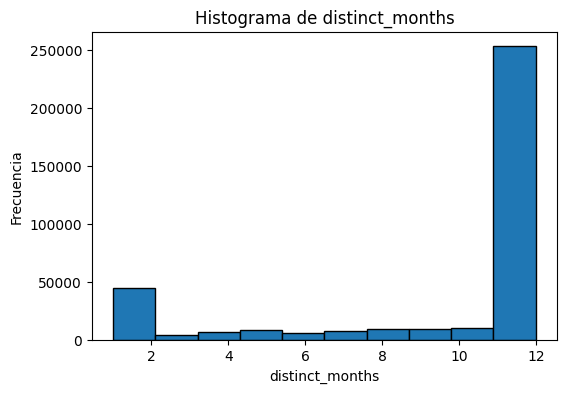

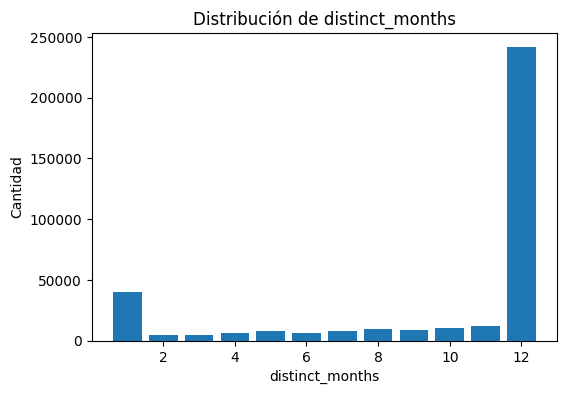

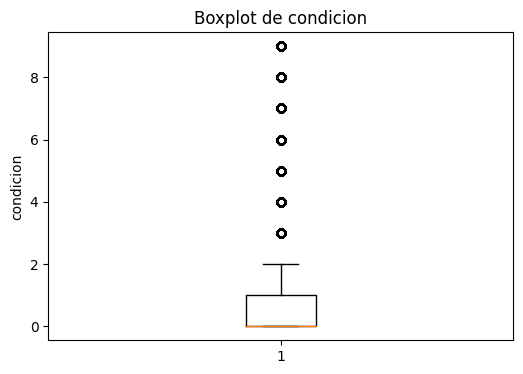

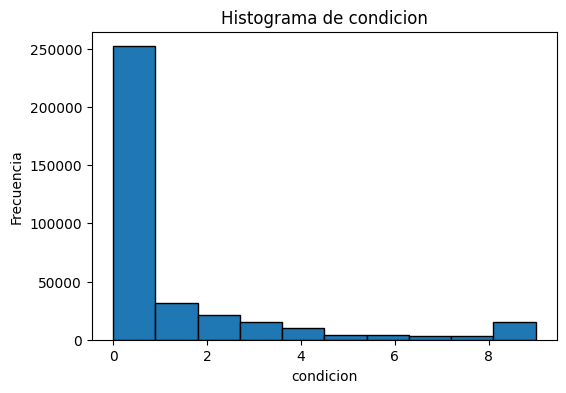

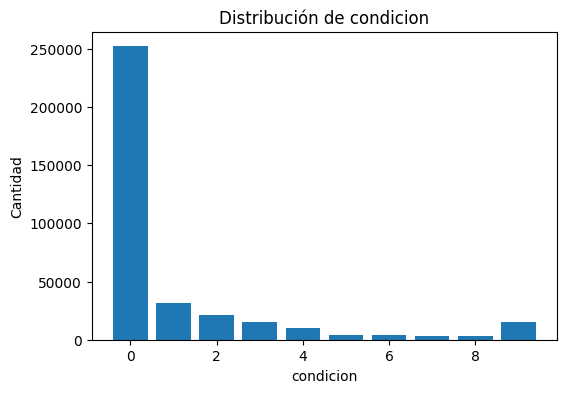

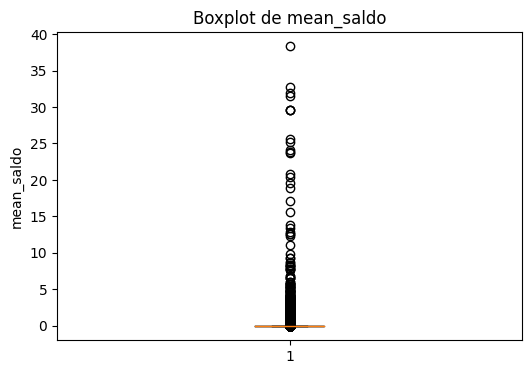

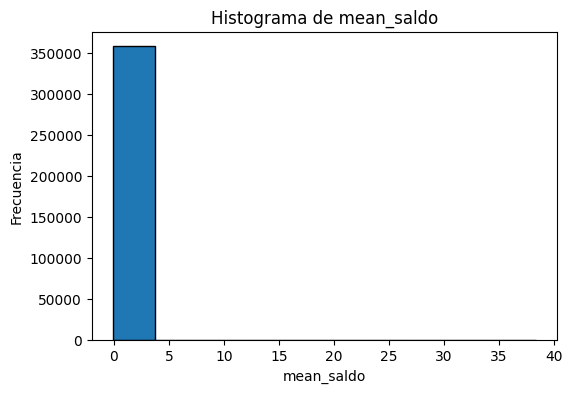

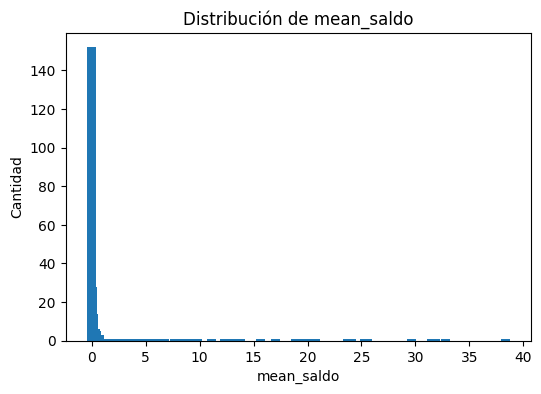

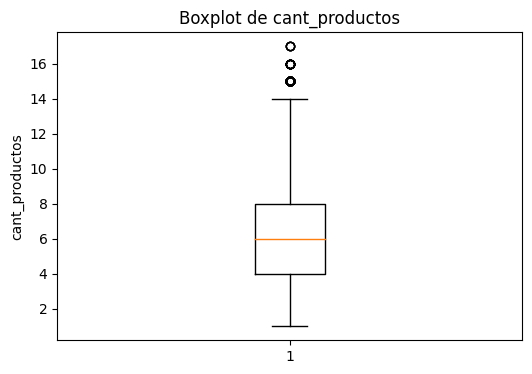

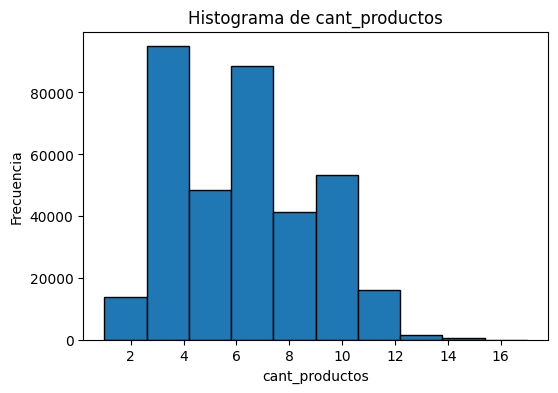

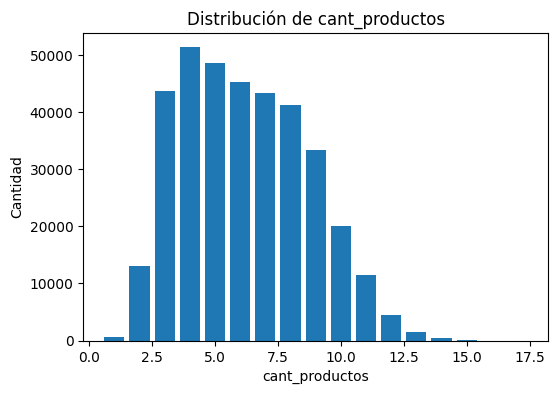

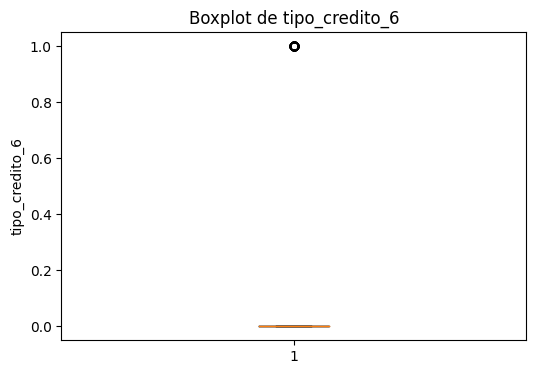

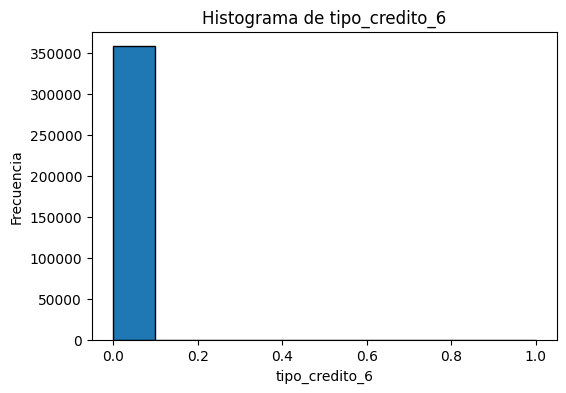

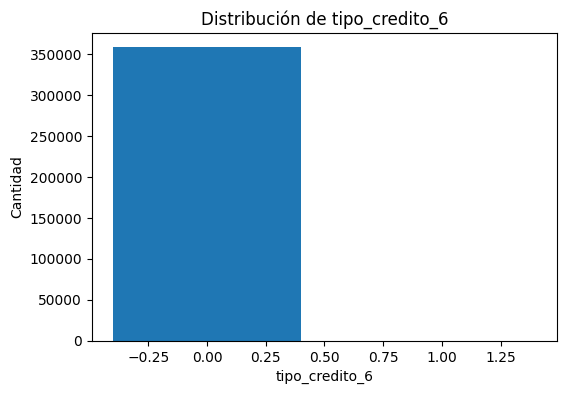

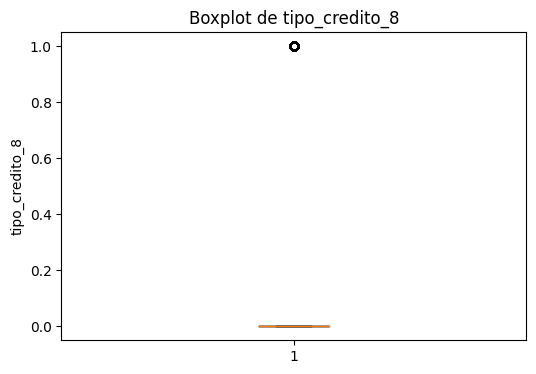

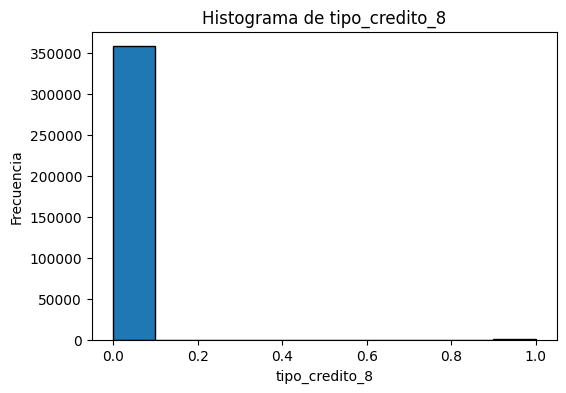

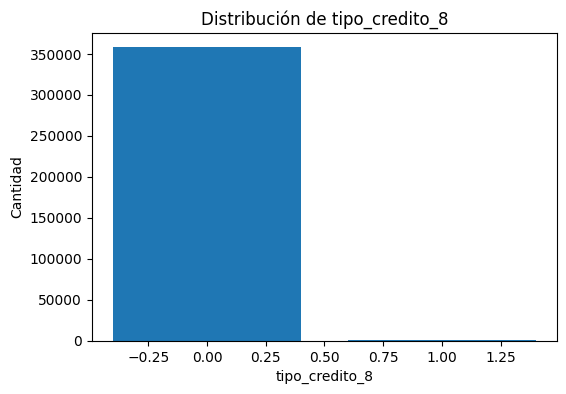

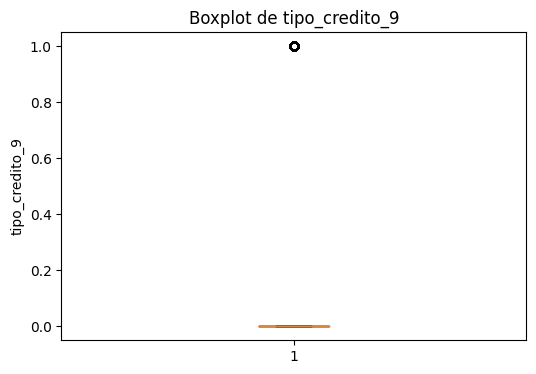

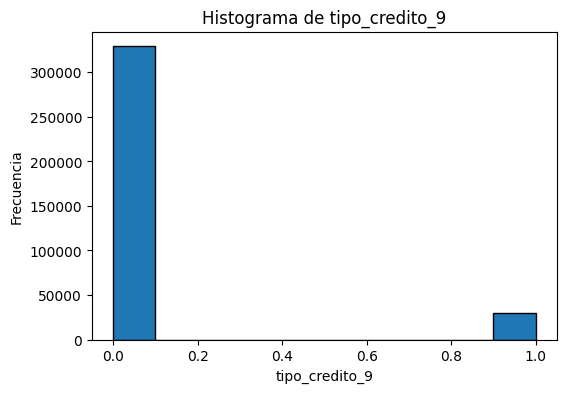

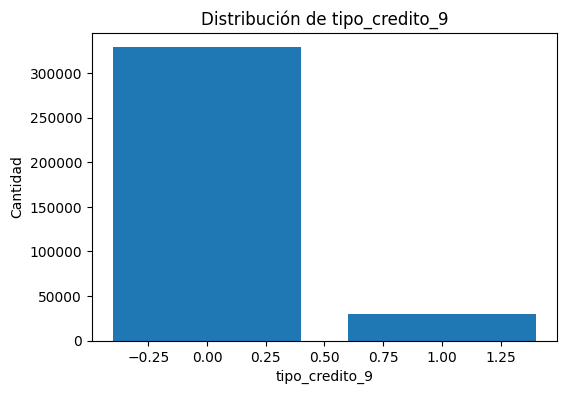

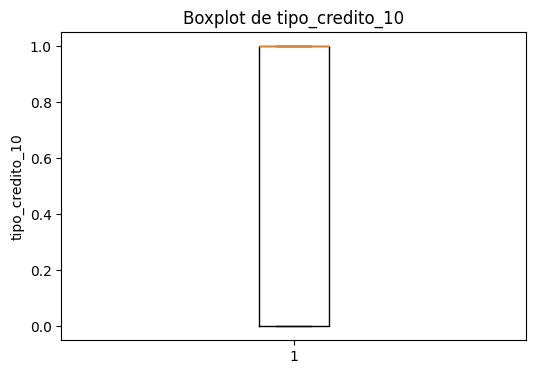

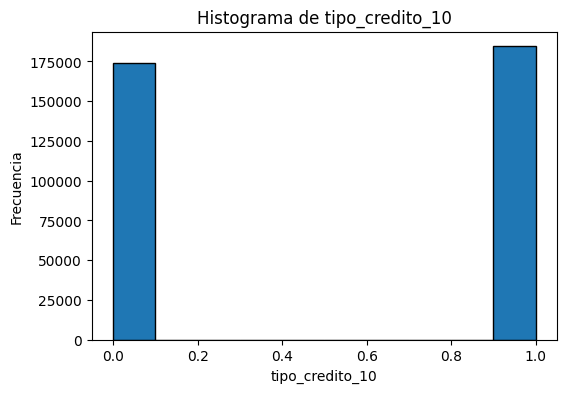

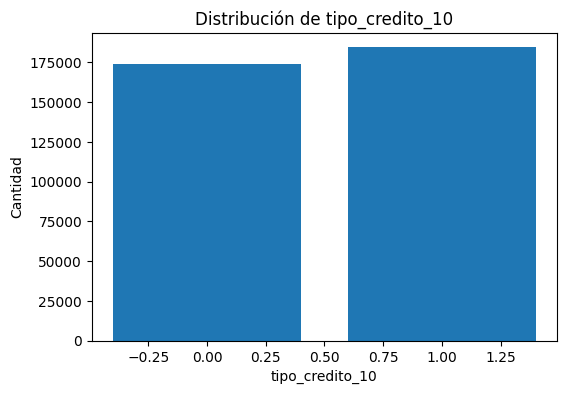

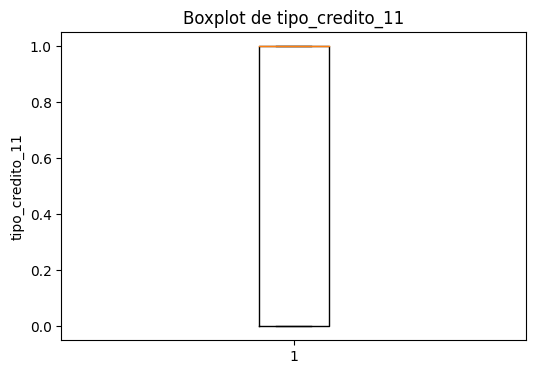

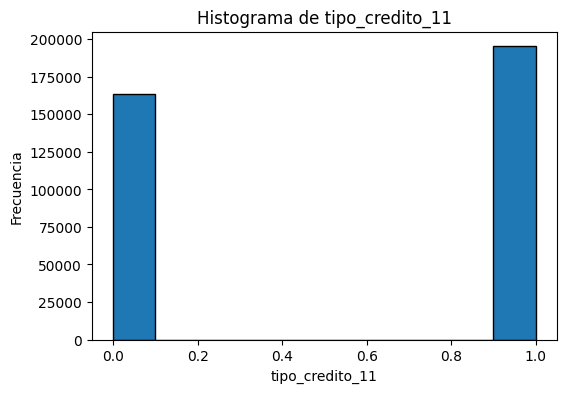

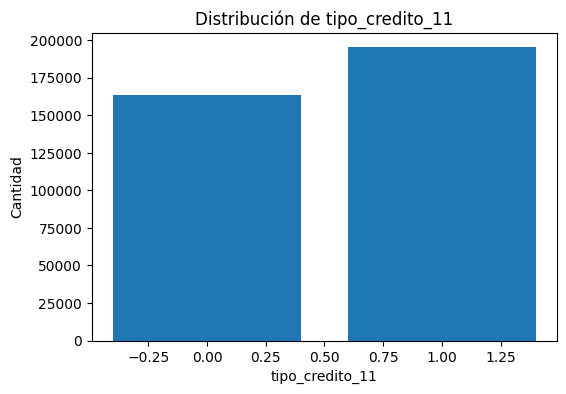

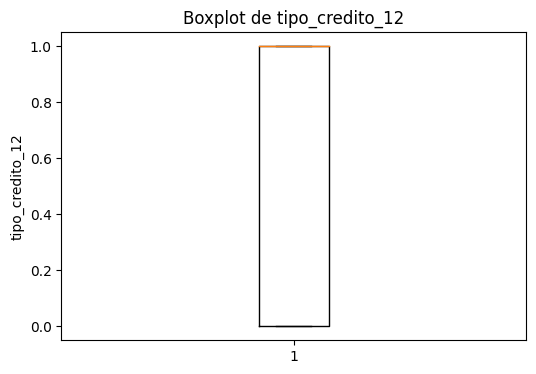

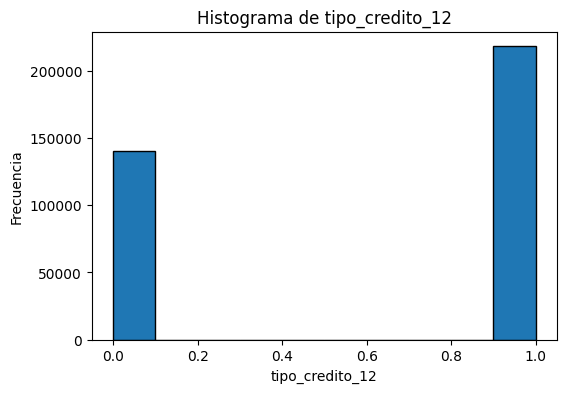

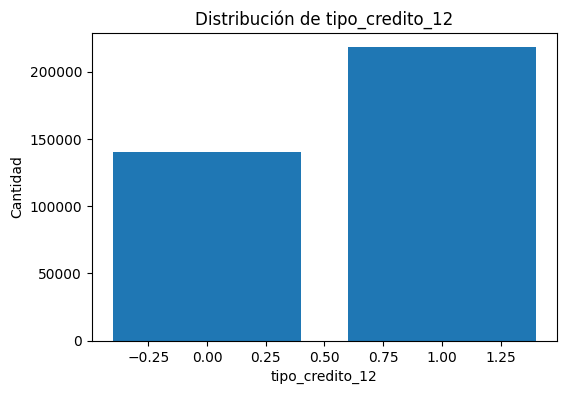

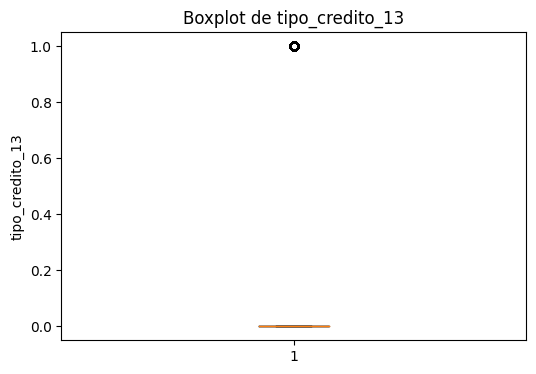

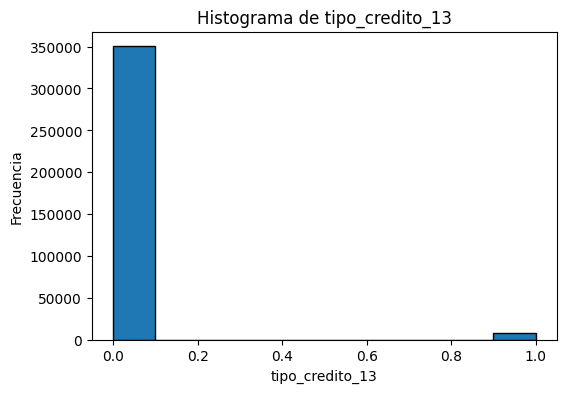

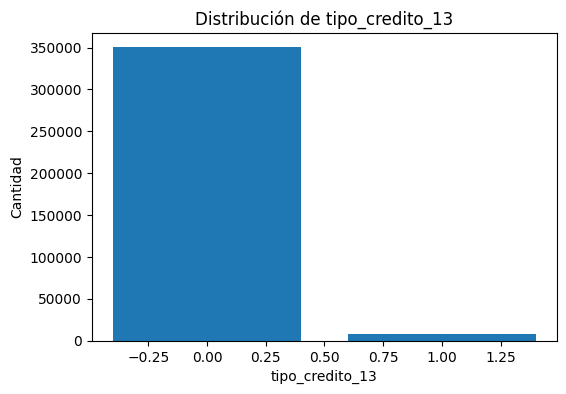

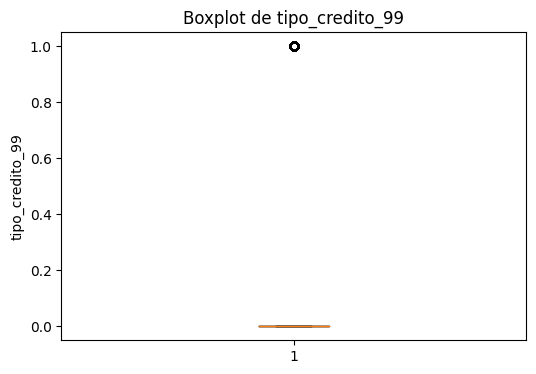

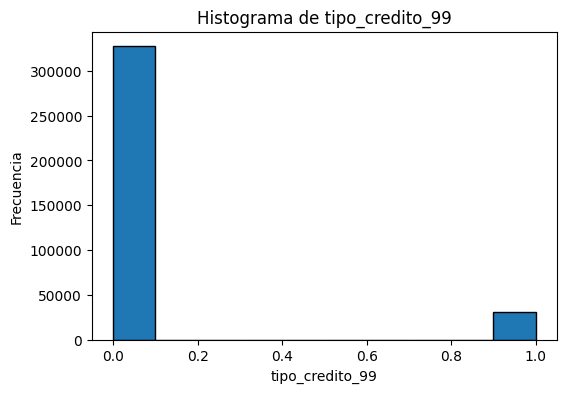

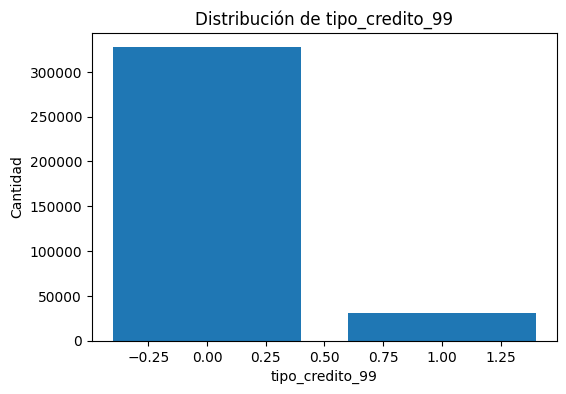

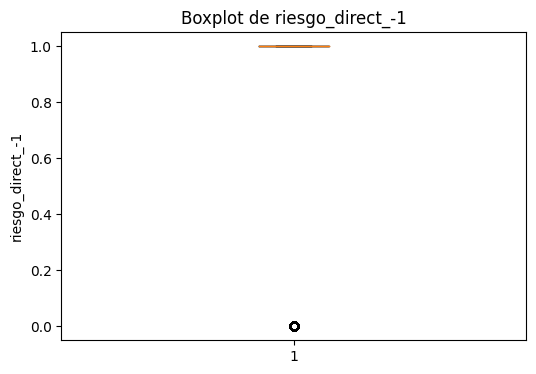

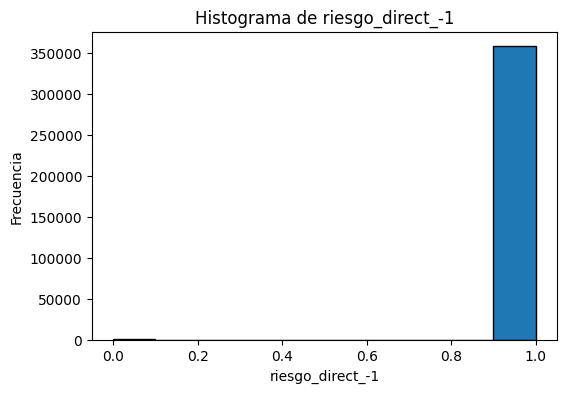

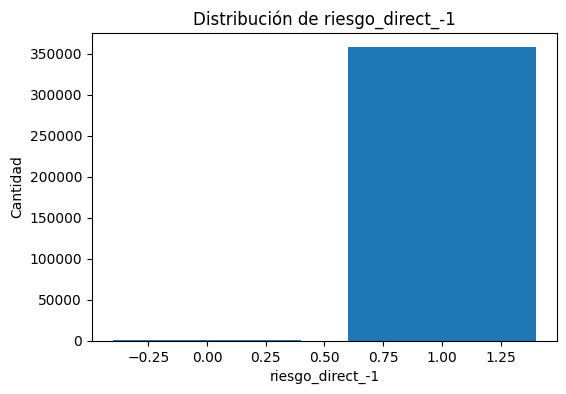

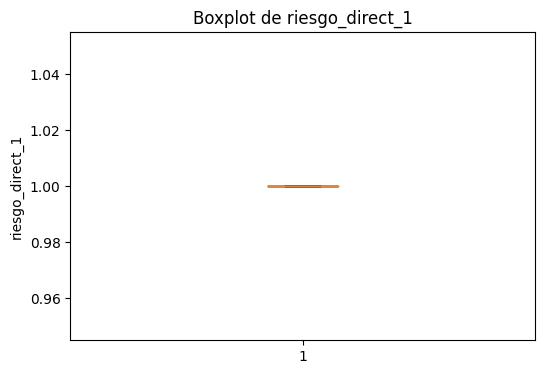

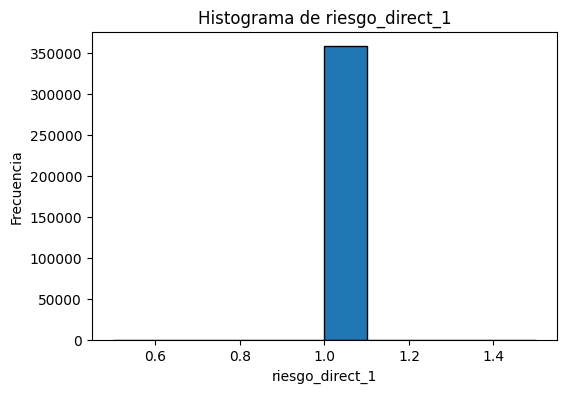

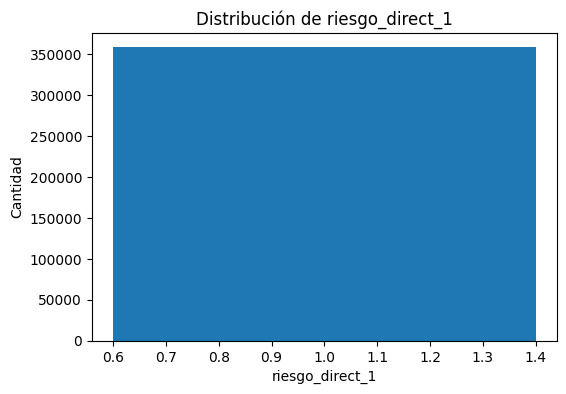

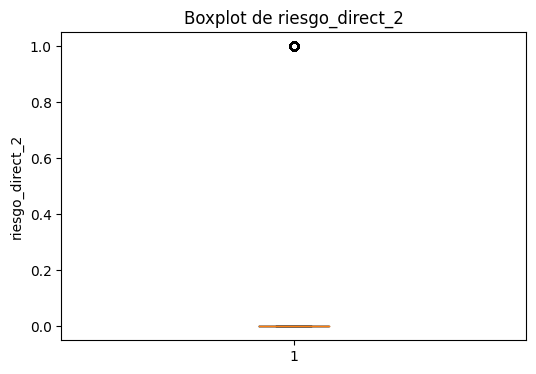

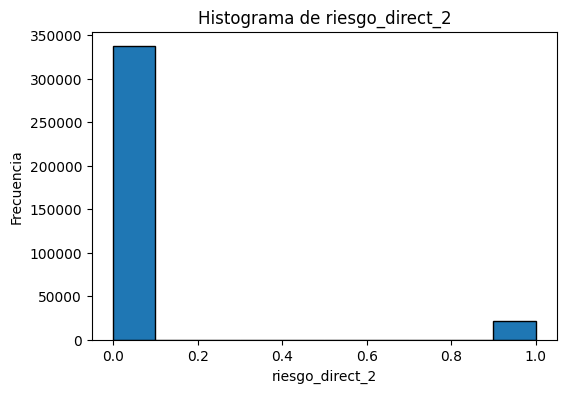

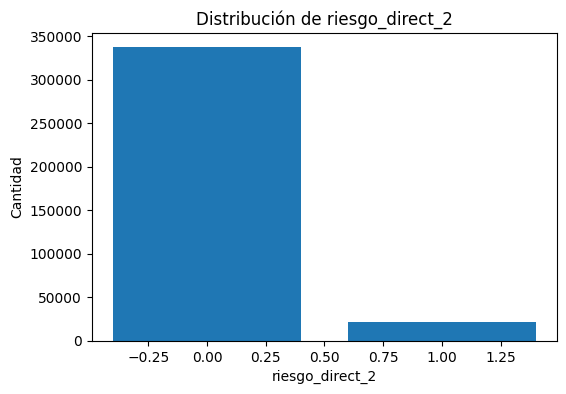

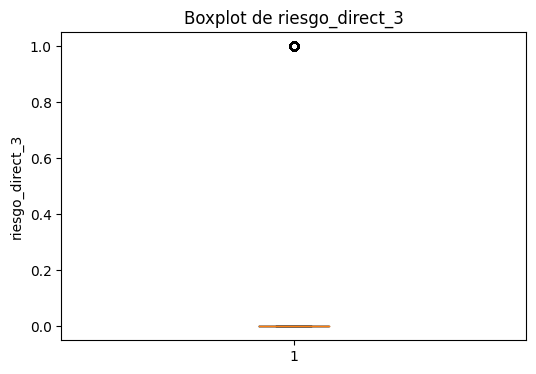

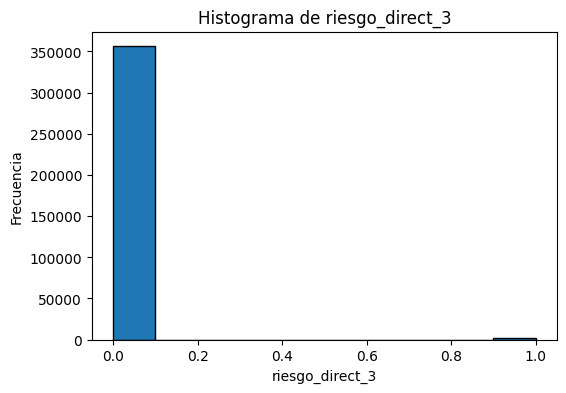

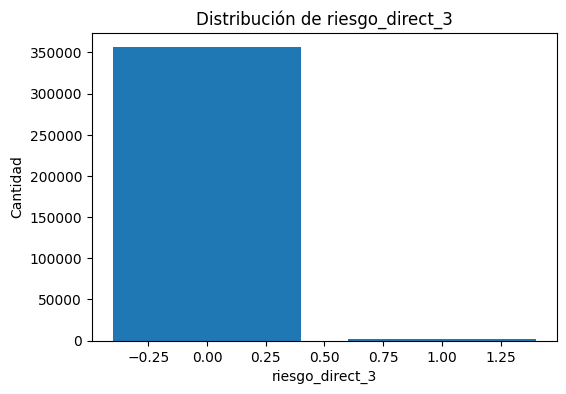

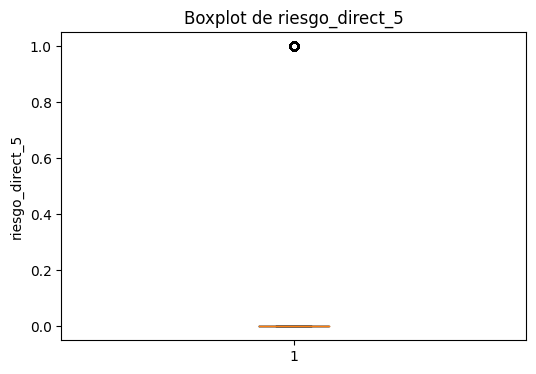

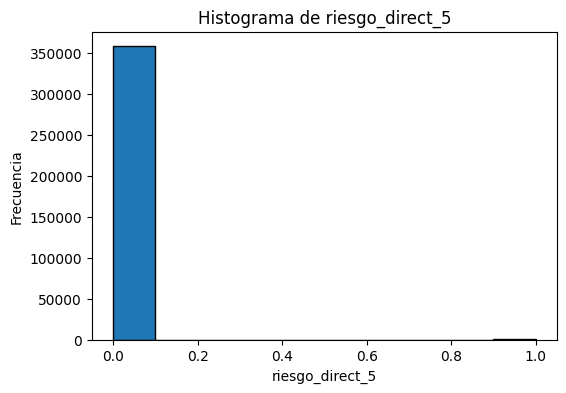

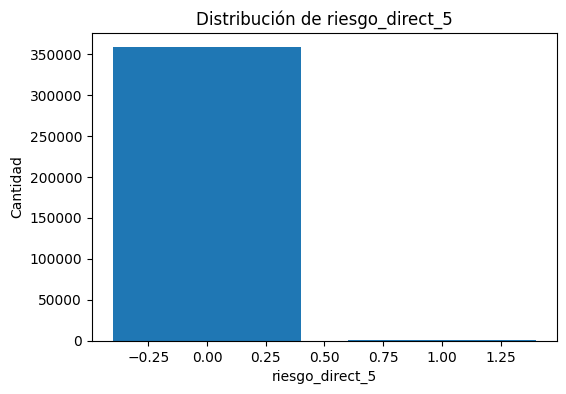

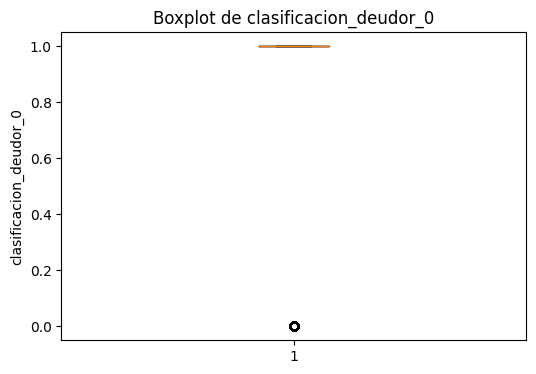

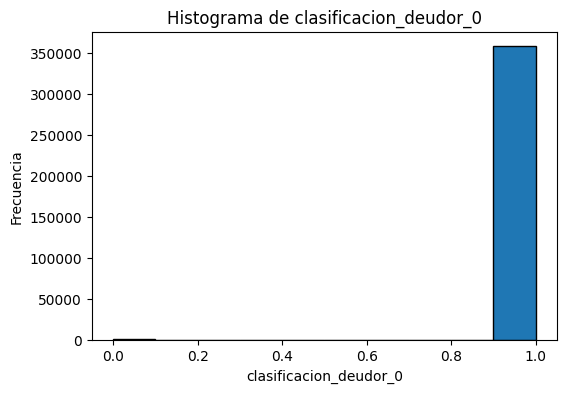

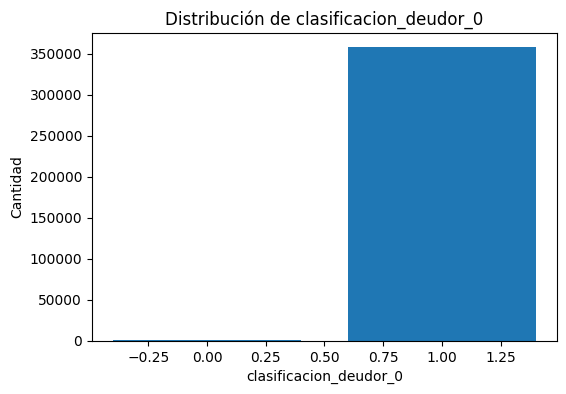

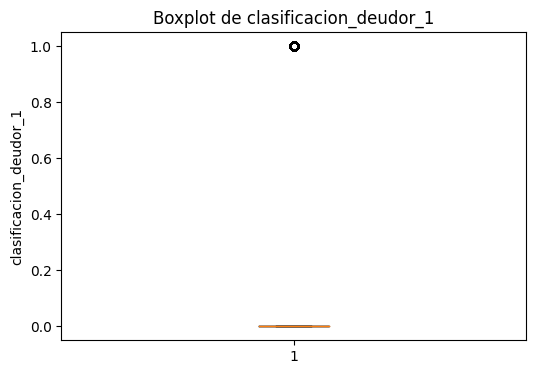

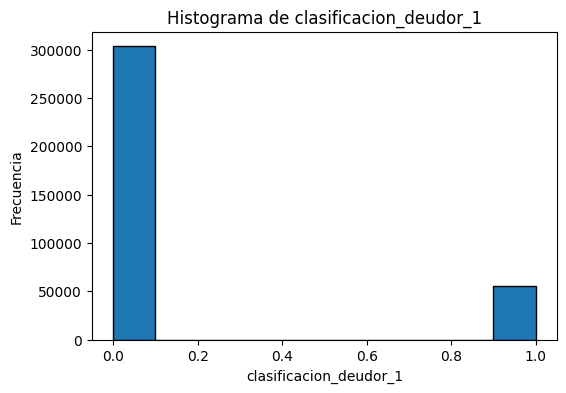

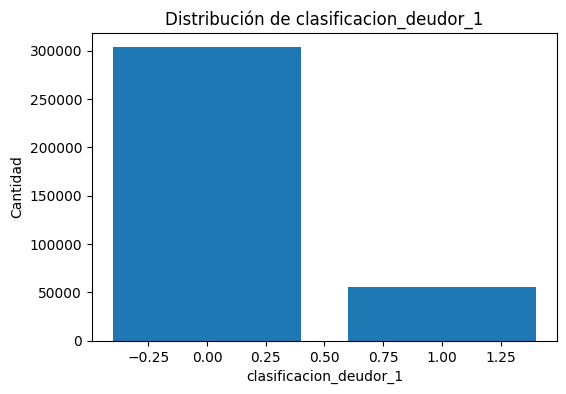

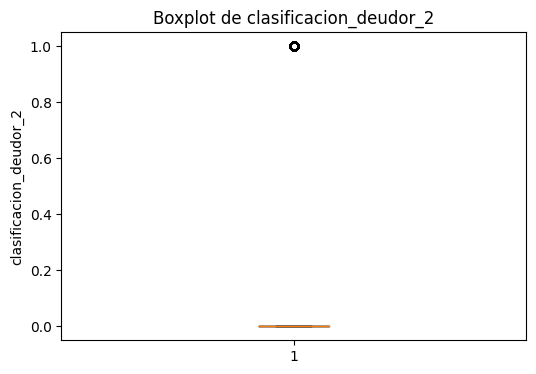

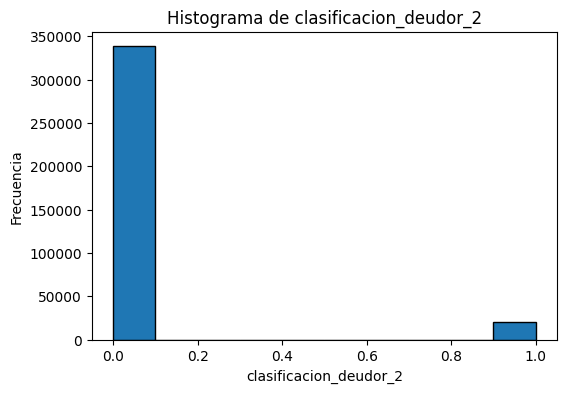

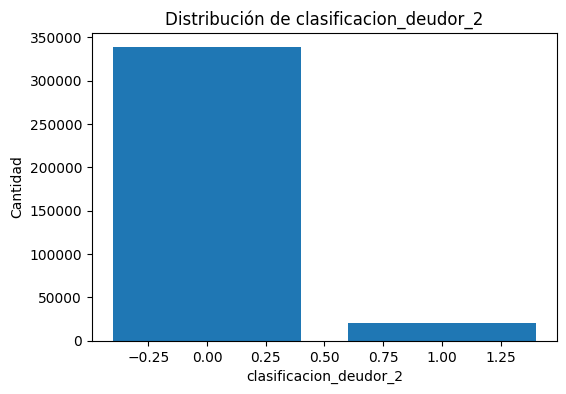

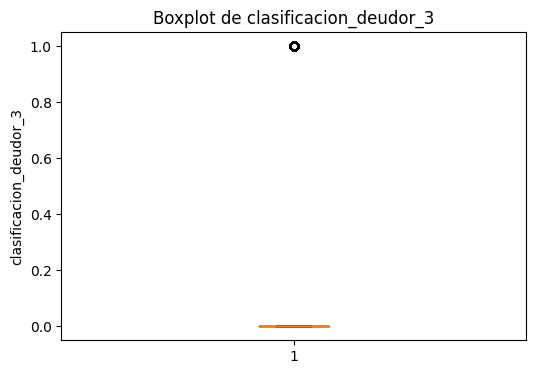

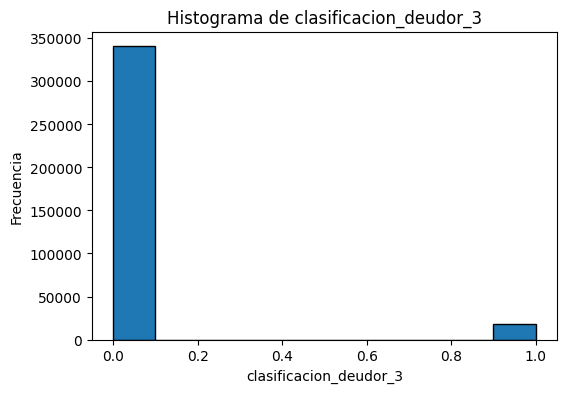

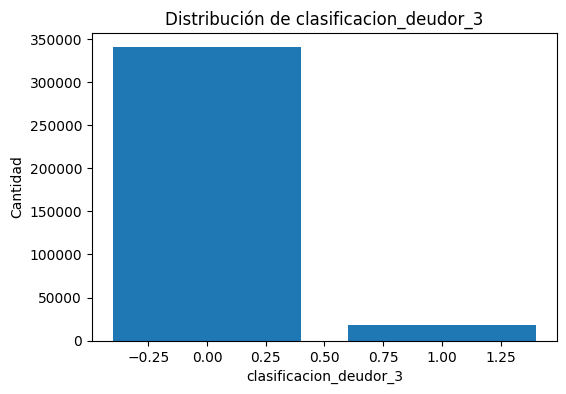

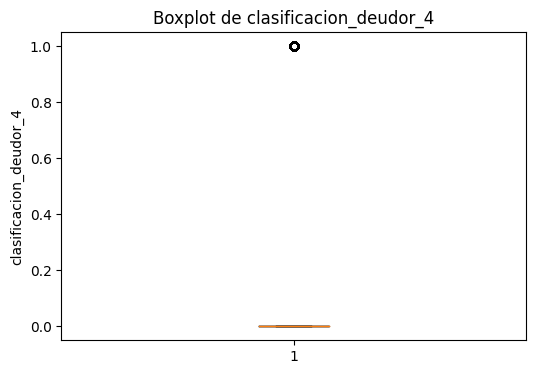

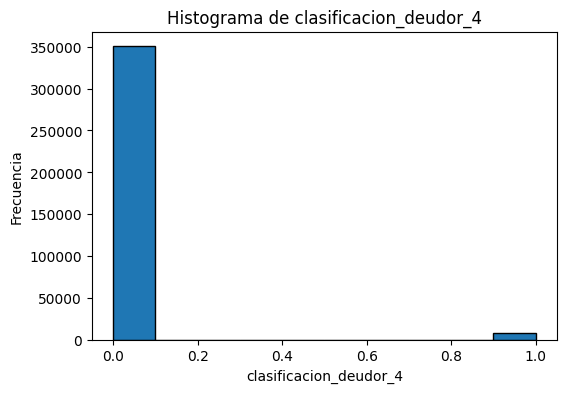

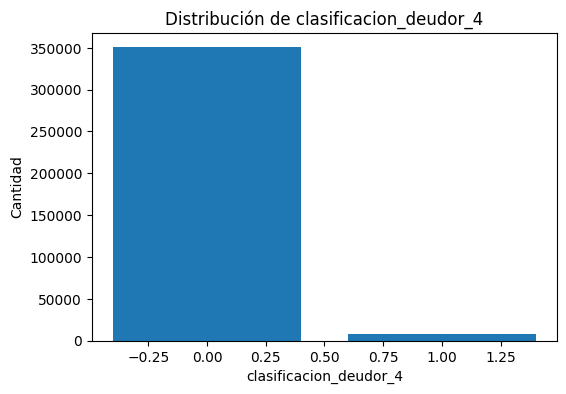

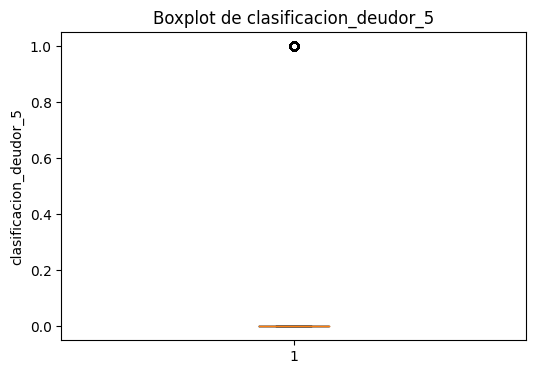

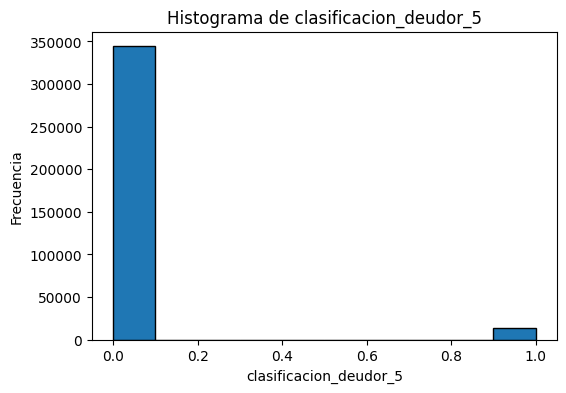

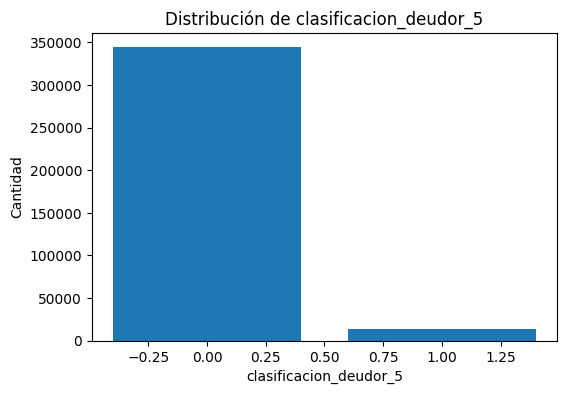

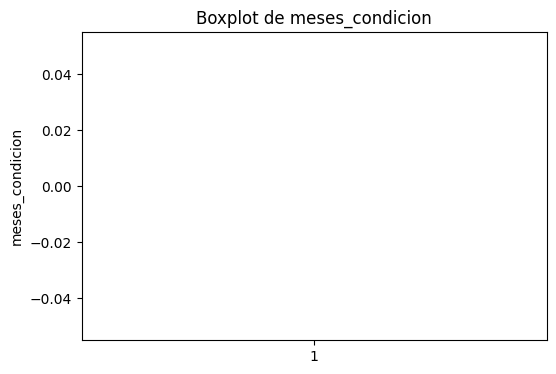

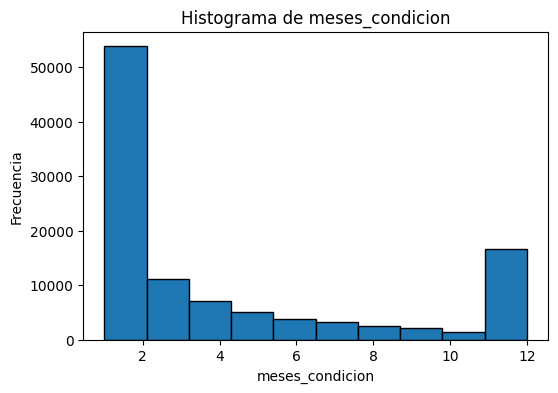

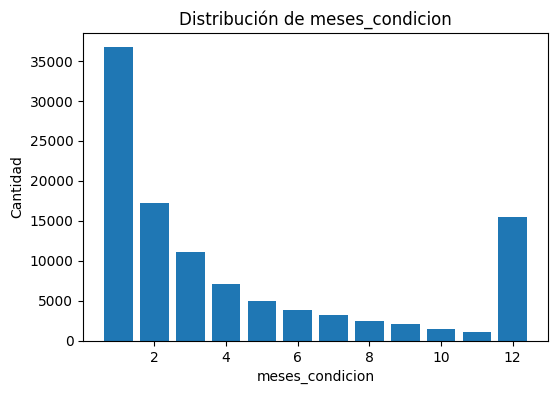

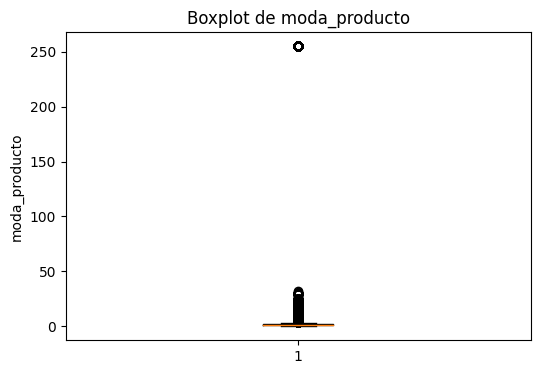

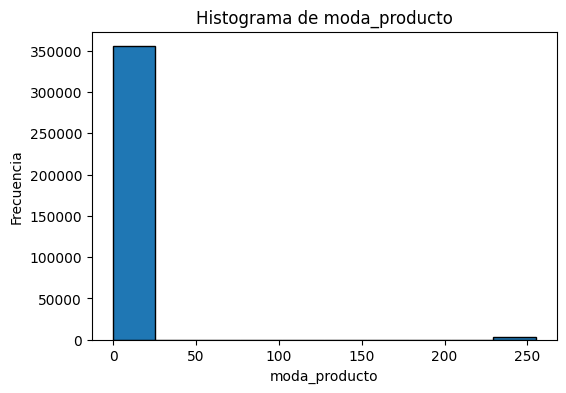

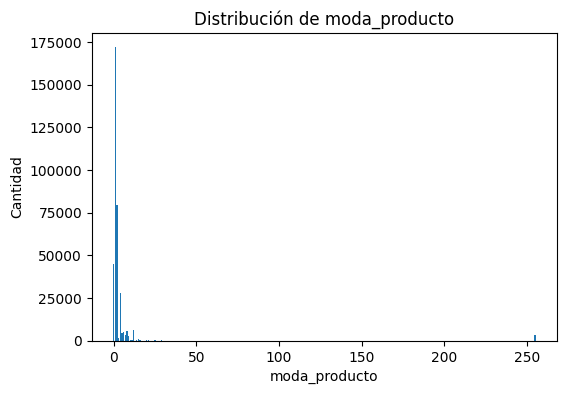

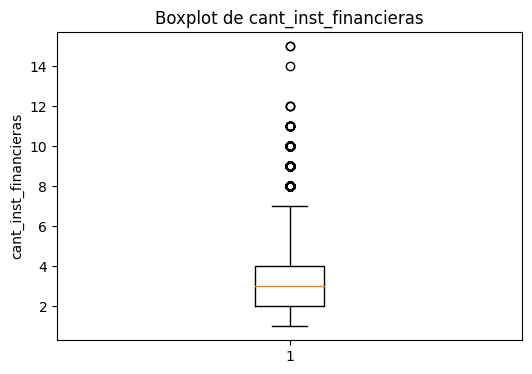

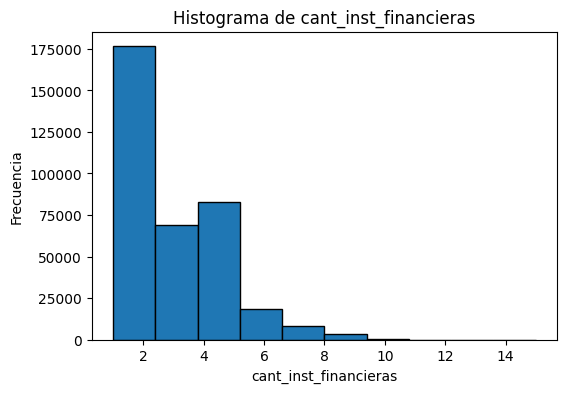

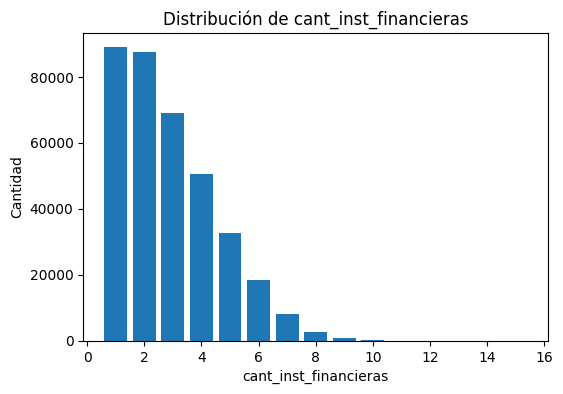

In [ ]:
import matplotlib.pyplot as plt
for column in aggregated_df.columns:
  if column != 'key_value':
      plt.figure(figsize=(6, 4))
      plt.title(f"Boxplot de {column}")
      plt.boxplot(aggregated_df[column])
      plt.ylabel(column)
      plt.show()

      plt.figure(figsize=(6, 4))
      plt.hist(aggregated_df[column], bins=10, edgecolor='k')
      plt.xlabel(column)
      plt.ylabel('Frecuencia')
      plt.title(f'Histograma de {column}')
      plt.show()

      plt.figure(figsize=(6, 4))
      cant_col = aggregated_df.groupby(column).size().reset_index(name='count')
      plt.bar(cant_col[column], cant_col['count'])
      plt.xlabel(f'{column}')
      plt.ylabel('Cantidad')
      plt.title(f'Distribución de {column}')
      plt.show()

In [ ]:
#cant_col = df_train.groupby('codmes').size().reset_index(name='count')
#cant_col
#cant_col = aggregated_df.groupby('distinct_months').size().reset_index(name='count')
#cant_col

In [ ]:
# Guardar los datos en un archivo CSV
nombre_archivo_csv = 'rcc_train_unico.csv'
aggregated_df.to_csv(nombre_archivo_csv, index=True)

print("Datos guardados exitosamente en el archivo:", nombre_archivo_csv)
#Mueve el archivo CSV al directorio de Google Drive
import shutil
ruta_destino = '/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/'
shutil.move('rcc_train_unico.csv', ruta_destino + 'rcc_train_unico.csv')

Datos guardados exitosamente en el archivo: rcc_train_unico.csv


'/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/rcc_train_unico.csv'

In [ ]:
#Liberar espacio en memoria
import gc
del df_train
gc.collect()

19536985

# **Exploración de data set se_train**

In [ ]:
#Importar las librerias necesarias para el proyecto
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import re
from google.colab import files

In [ ]:
#Obtener los datos del archivo del historíal de crediticio
ruta_se_train = '/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/se_train.csv'
df_se_train = pd.read_csv(ruta_se_train)


In [ ]:
df_se_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358428 entries, 0 to 358427
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   key_value      358428 non-null  int64  
 1   edad           354663 non-null  float64
 2   sexo           358428 non-null  int64  
 3   est_cvl        358428 non-null  int64  
 4   sit_lab        358428 non-null  int64  
 5   cod_ocu        358428 non-null  int64  
 6   ctd_hijos      358428 non-null  float64
 7   flg_sin_email  358428 non-null  int64  
 8   ctd_veh        358428 non-null  float64
 9   cod_ubi        354255 non-null  float64
 10  lgr_vot        358428 non-null  int64  
 11  prv            358428 non-null  int64  
 12  dto            358428 non-null  int64  
 13  rgn            358428 non-null  int64  
 14  tip_lvledu     358428 non-null  int64  
dtypes: float64(4), int64(11)
memory usage: 41.0 MB


In [ ]:
#Identificar valores unicos por cada atributo
print('edad', df_se_train['edad'].unique())
print('sexo', df_se_train['sexo'].unique())
print('estado civil', df_se_train['est_cvl'].unique())
print('situación laboral', df_se_train['sit_lab'].unique())
print('codigo ocupación', df_se_train['cod_ocu'].unique())
print('cantidad de hijos', df_se_train['ctd_hijos'].unique())
print('bandera sin email', df_se_train['flg_sin_email'].unique())
print('codigo ubicación', df_se_train['cod_ubi'].unique())
print('lugar votación', df_se_train['lgr_vot'].unique())
print('provincia', df_se_train['prv'].unique())
print('departamento', df_se_train['dto'].unique())
print('región', df_se_train['rgn'].unique())
print('tipo de nivel educativo', df_se_train['tip_lvledu'].unique())

edad [-9.83651293e-01  9.52652605e-04  5.31124008e-01 -1.13512882e+00
 -1.43808388e+00  1.81868301e+00  2.50033190e+00  9.09817833e-01
  1.06129536e+00  1.52430183e-01  1.21277289e+00 -7.56434998e-01
  9.85556598e-01 -1.05939006e+00 -5.29218703e-01 -1.21086759e+00
  1.36425042e+00  3.79646478e-01  1.43998919e+00  1.59146672e+00
  6.82601538e-01  8.34079068e-01  2.27311560e+00  3.03907713e-01
 -1.28660635e+00 -6.80696233e-01 -4.53479938e-01  2.04589931e+00
 -1.36234512e+00 -9.07912528e-01  1.13703413e+00 -6.04957468e-01
  1.74294425e+00 -3.02002408e-01  1.97016054e+00  2.28168948e-01
  2.42459313e+00 -3.77741173e-01  7.58340303e-01 -8.32173763e-01
  7.66914176e-02             nan -7.47861124e-02 -1.50524877e-01
  4.55385243e-01 -2.26263642e-01  3.03050325e+00  2.87902572e+00
  1.28851166e+00  6.06862773e-01 -1.51382265e+00  1.51572795e+00
  2.19737684e+00 -1.58956141e+00  1.66720548e+00  1.89442178e+00
  2.80328696e+00  3.40919708e+00  2.65180943e+00  2.12163807e+00
  2.57607066e+00  2.

In [ ]:
#Se identifican los valores nulos y se sustituyen por la mediana
mediana_edad = df_se_train['edad'].median(skipna=True)
df_se_train['edad'].fillna(mediana_edad, inplace=True)
df_se_train['edad'].nunique()

80

In [ ]:
#Visualizar valores máximos y mínimos, para reasignar números enteros que permitan
#la interpretación de los datos
print('Edad miníma: ', df_se_train['edad'].min())
print('Edad máxima: ', df_se_train['edad'].max())


Edad miníma:  -2.42268782826828
Edad máxima:  5.302666204514757


In [ ]:
#Calcular y asignar las edades
import pandas as pd
import numpy as np
def mapear_edad(valor_decimal):
  return int(np.round((valor_decimal - (-2.42268782826828)) * (100 - 20) / (5.302666204514757 - (-2.42268782826828)) + 20))

df_se_train['edad'] = df_se_train['edad'].apply(mapear_edad)

In [ ]:
#Identificar la cantidad de atributos unicos por cada atributo
print('edad', df_se_train['edad'].nunique())
print('sexo', df_se_train['sexo'].nunique())
print('estado civil', df_se_train['est_cvl'].nunique())
print('situación laboral', df_se_train['sit_lab'].nunique())
print('codigo ocupación', df_se_train['cod_ocu'].nunique())
print('cantidad de hijos', df_se_train['ctd_hijos'].nunique())
print('bandera sin email', df_se_train['flg_sin_email'].nunique())
print('codigo ubicación', df_se_train['cod_ubi'].nunique())
print('lugar votación', df_se_train['lgr_vot'].nunique())
print('privincia', df_se_train['prv'].nunique())
print('departamento', df_se_train['dto'].nunique())
print('región', df_se_train['rgn'].nunique())
print('tipo de nivel educativo', df_se_train['tip_lvledu'].nunique())

edad 64
sexo 4
estado civil 6
situación laboral 4
codigo ocupación 39
cantidad de hijos 12
bandera sin email 2
codigo ubicación 2070
lugar votación 31
privincia 197
departamento 1662
región 7
tipo de nivel educativo 8


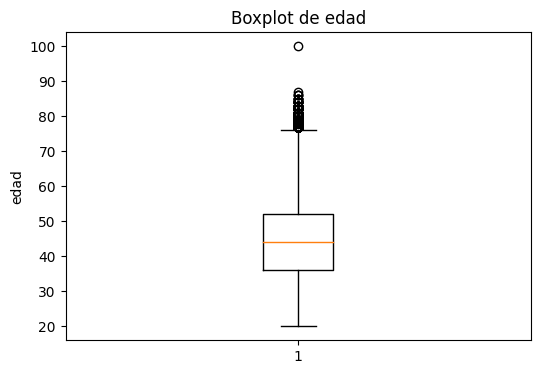

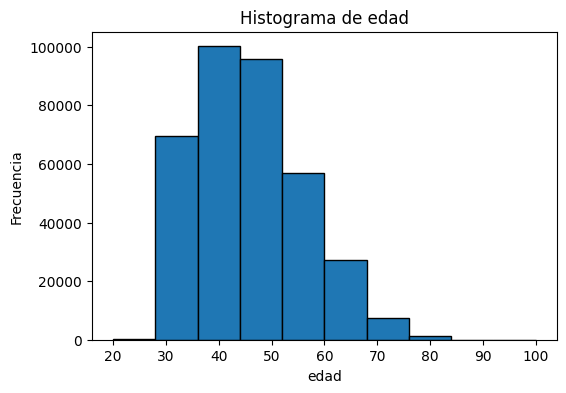

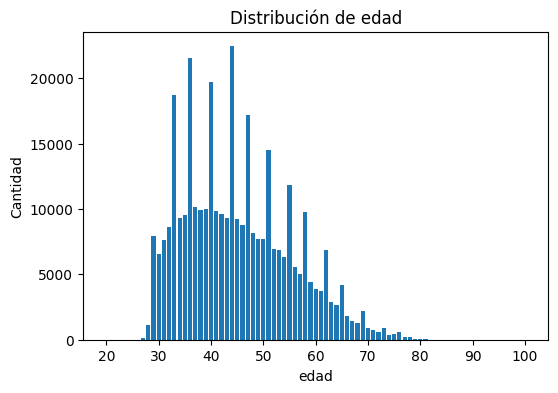

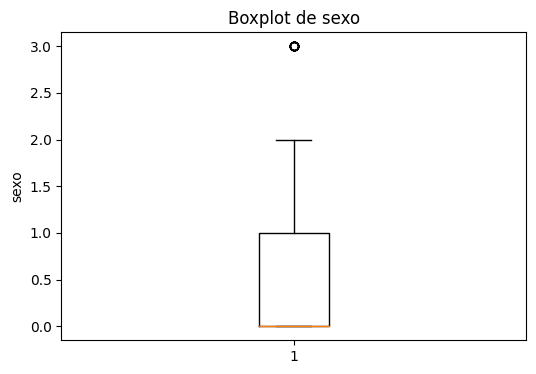

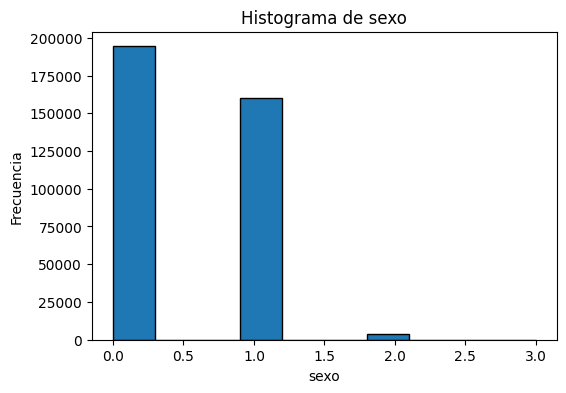

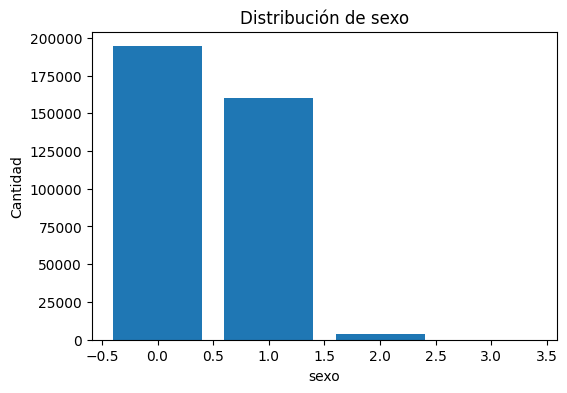

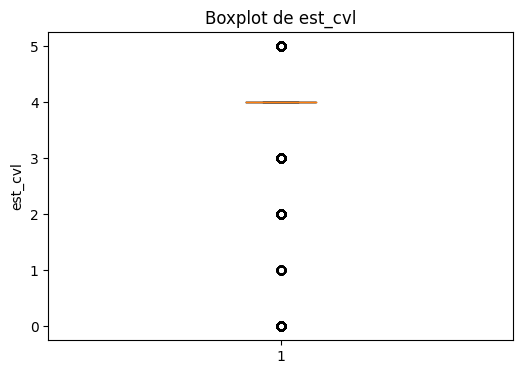

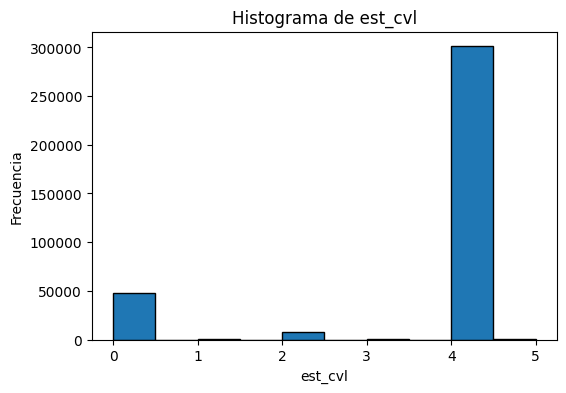

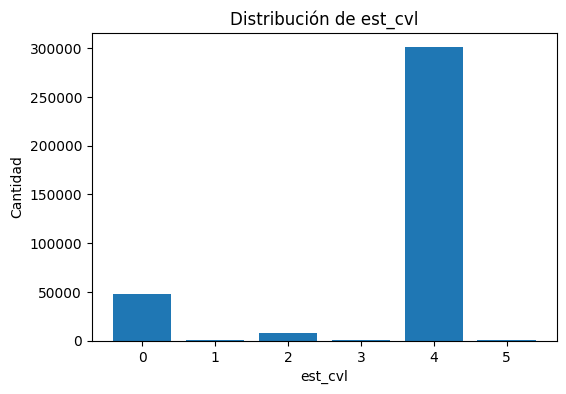

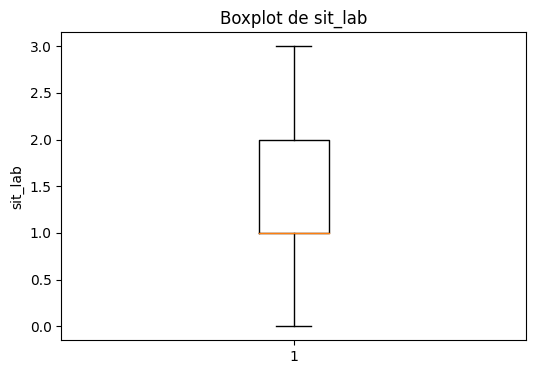

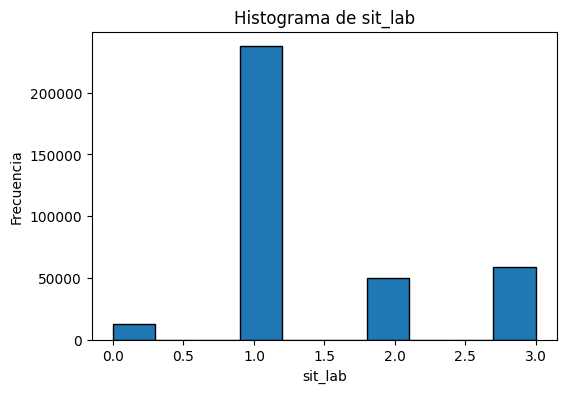

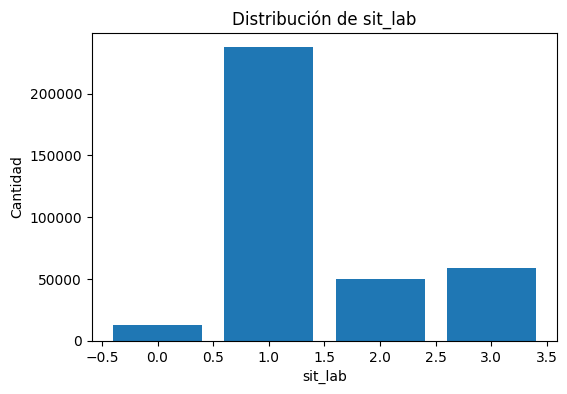

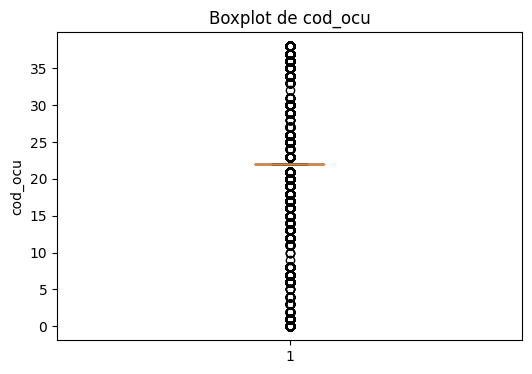

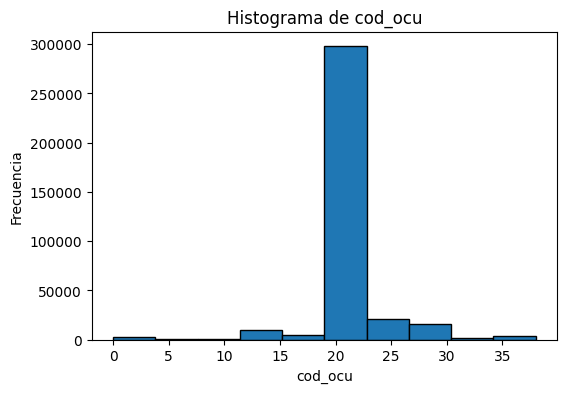

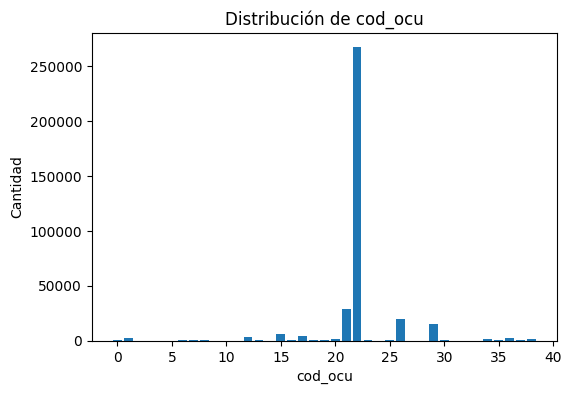

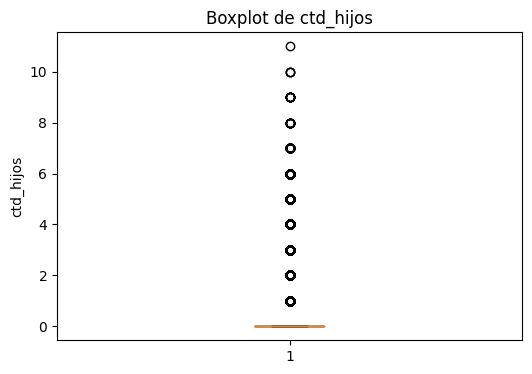

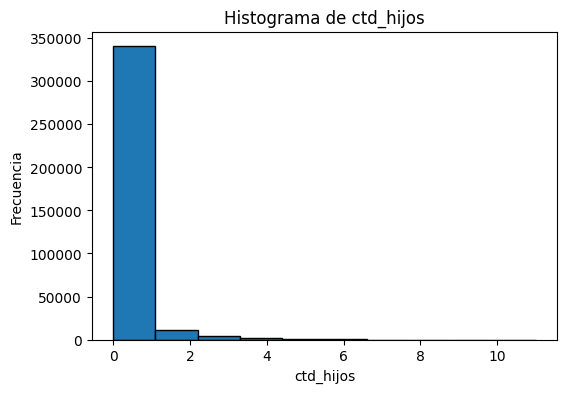

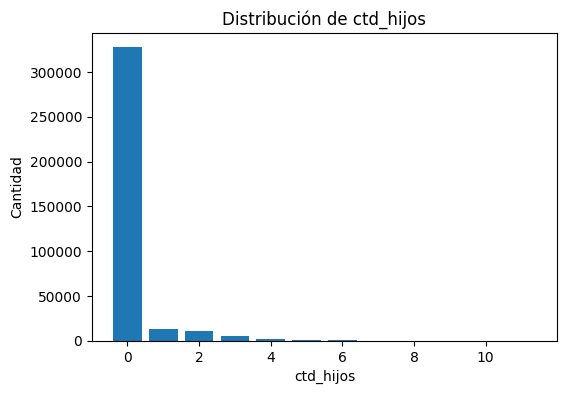

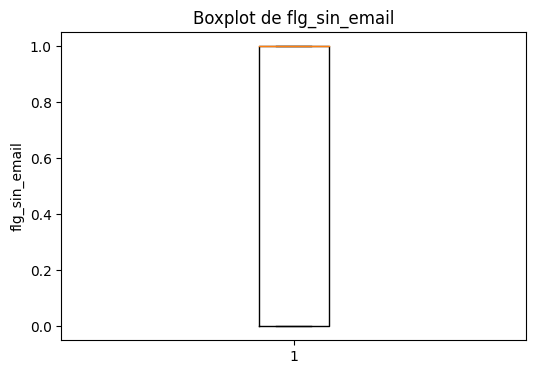

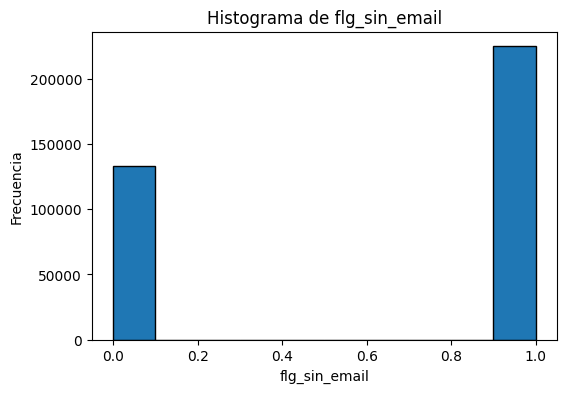

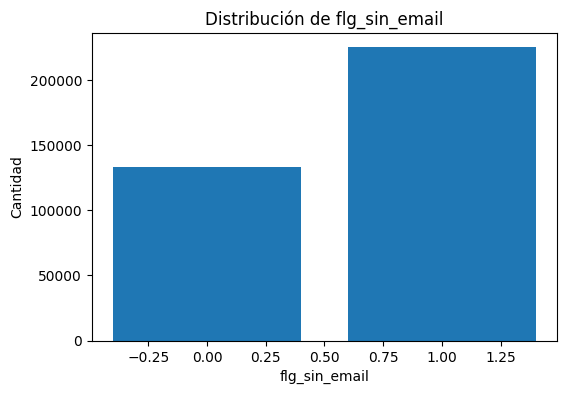

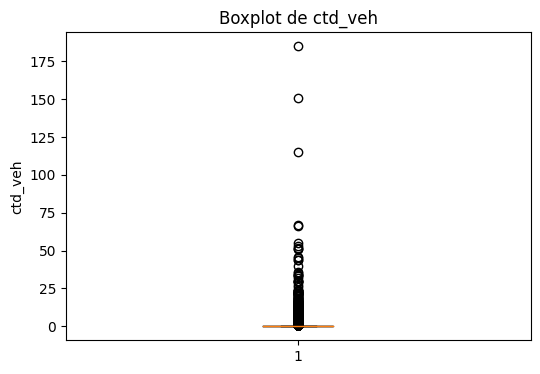

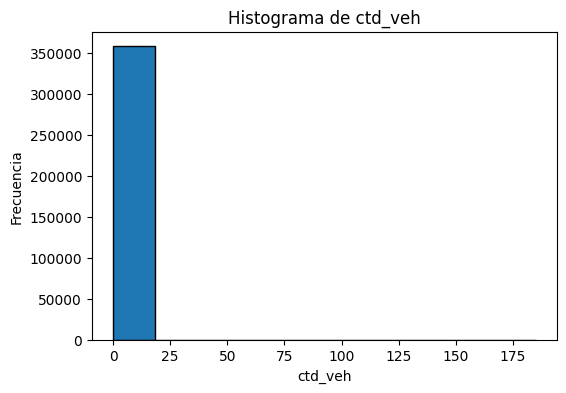

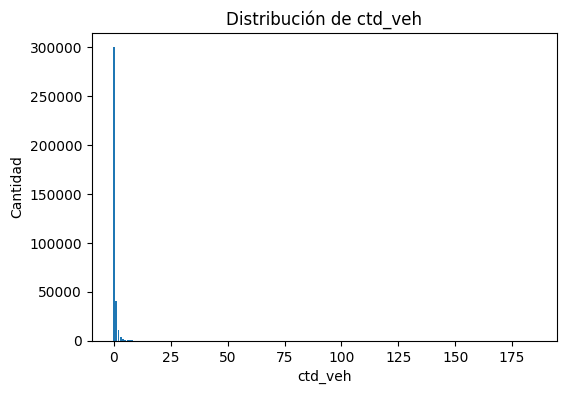

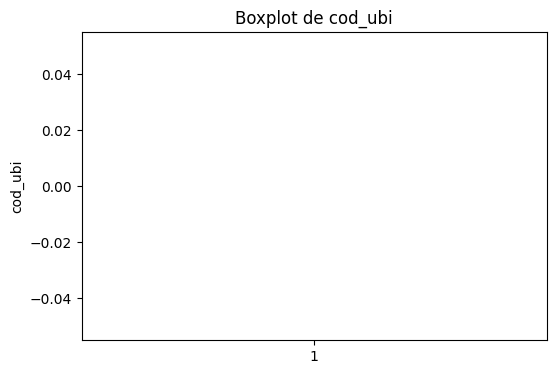

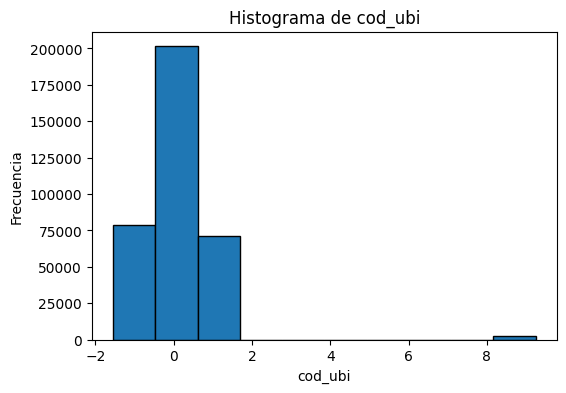

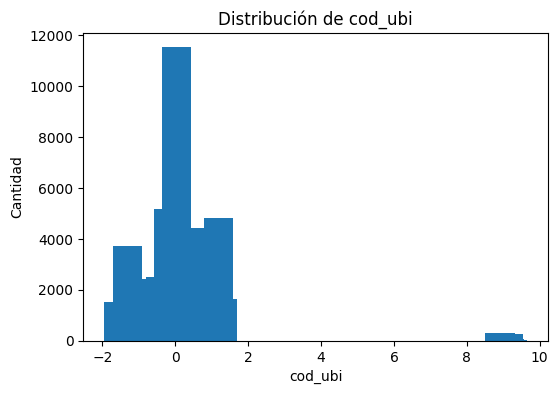

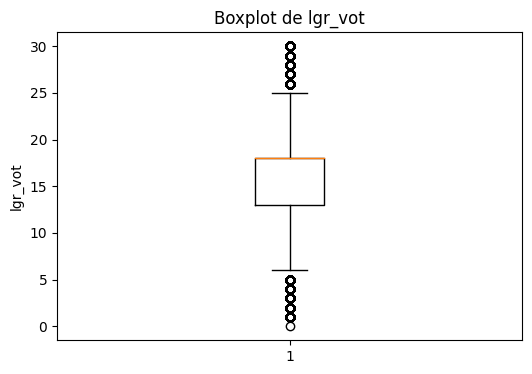

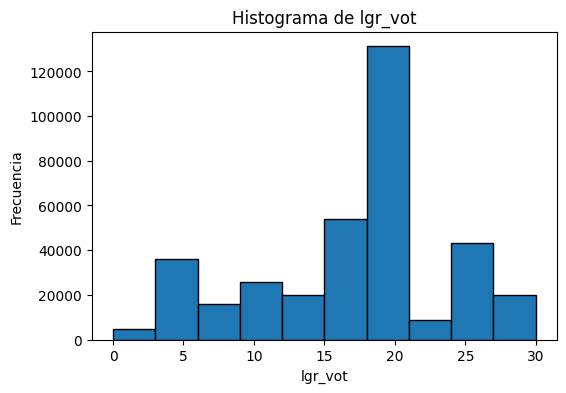

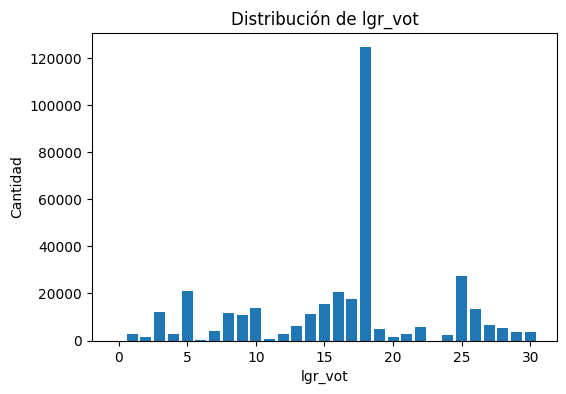

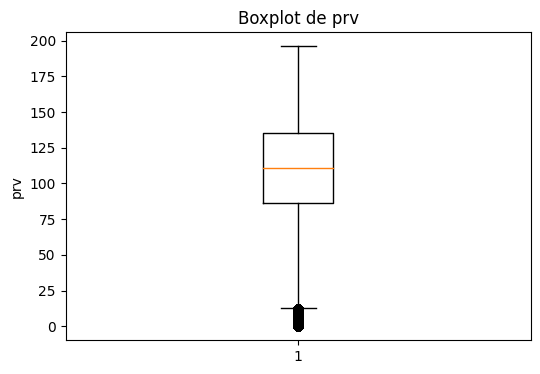

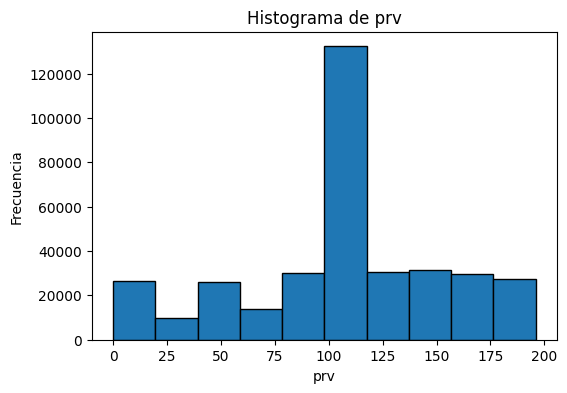

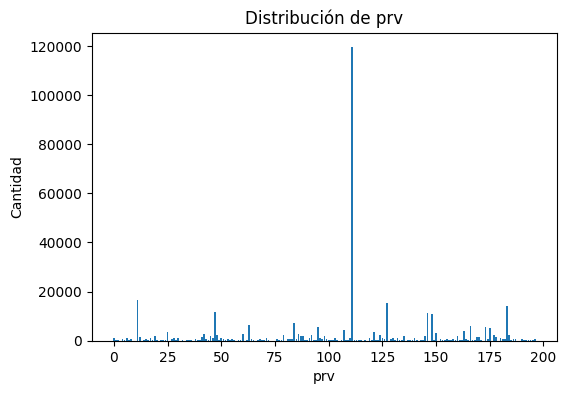

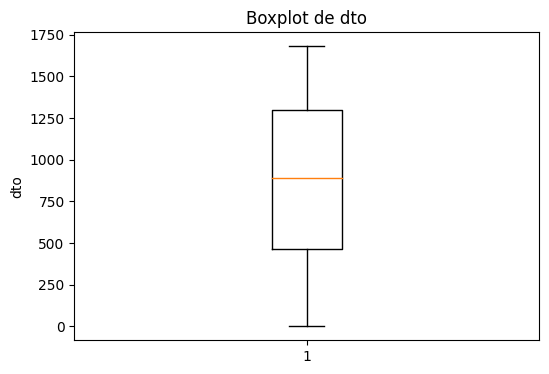

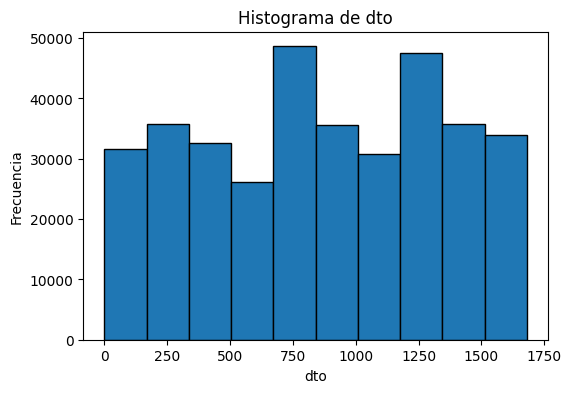

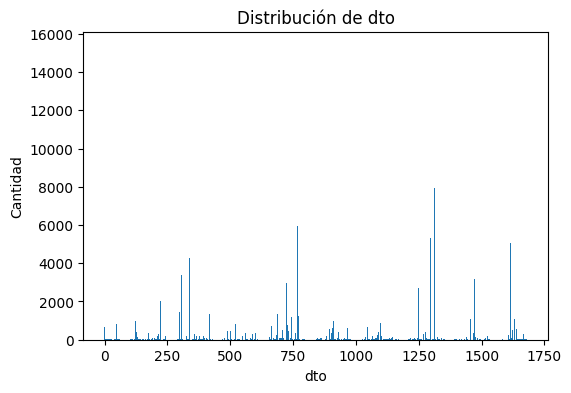

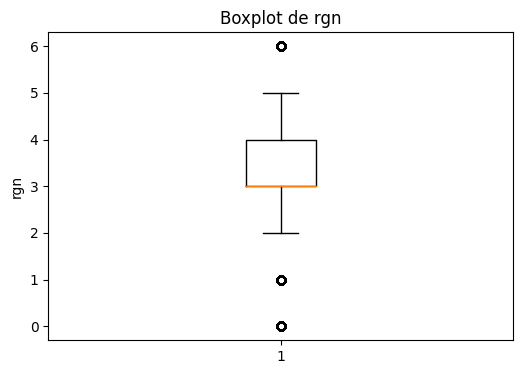

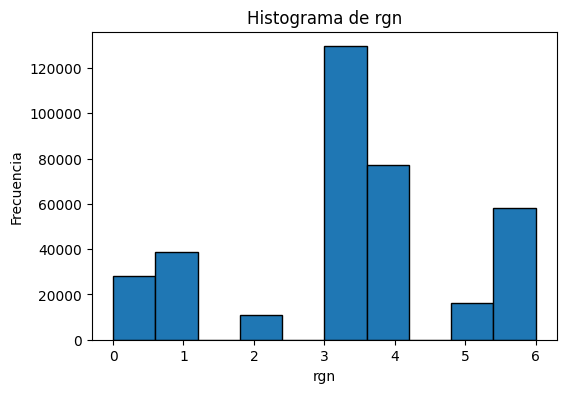

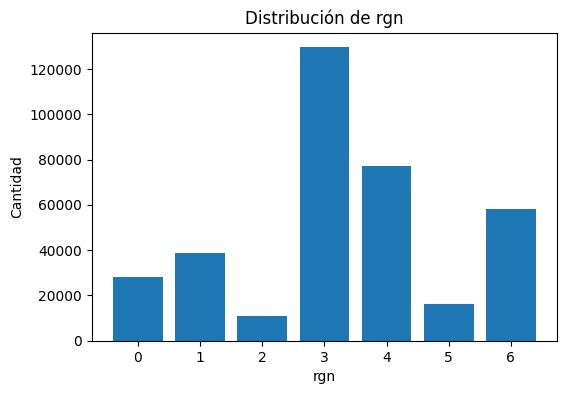

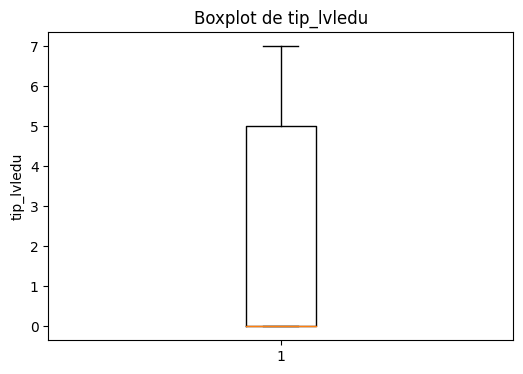

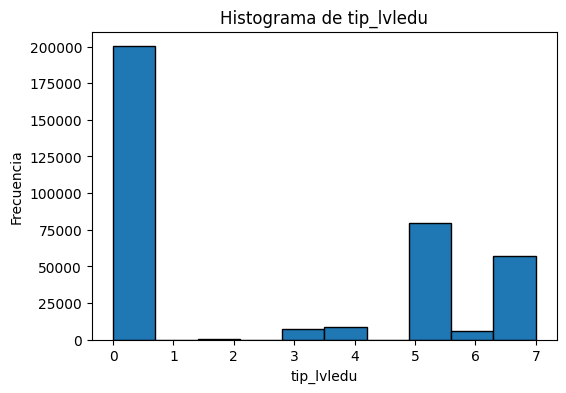

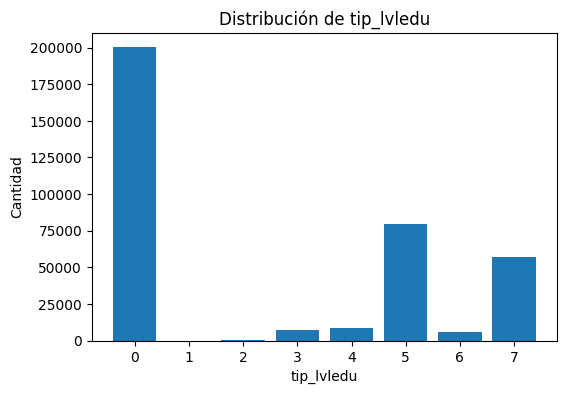

In [ ]:
#Graficar cada columna cuantitativa del set de datos, para tratar los valores
#atípicos
import matplotlib.pyplot as plt
for column in df_se_train.columns:
  if column != 'key_value':
      plt.figure(figsize=(6, 4))
      plt.title(f"Boxplot de {column}")
      plt.boxplot(df_se_train[column])
      plt.ylabel(column)
      plt.show()

      plt.figure(figsize=(6, 4))
      plt.hist(df_se_train[column], bins=10, edgecolor='k')
      plt.xlabel(column)
      plt.ylabel('Frecuencia')
      plt.title(f'Histograma de {column}')
      plt.show()

      plt.figure(figsize=(6, 4))
      cant_col = df_se_train.groupby(column).size().reset_index(name='count')
      plt.bar(cant_col[column], cant_col['count'])
      plt.xlabel(f'{column}')
      plt.ylabel('Cantidad')
      plt.title(f'Distribución de {column}')
      plt.show()

In [ ]:
#df_se_train

,key_value,edad,sexo,est_cvl,sit_lab,cod_ocu,ctd_hijos,flg_sin_email,ctd_veh,cod_ubi,lgr_vot,prv,dto,rgn,tip_lvledu
0,0,35,1,4,2,22,0.0,1,0.0,-0.070167,17,47,687,4,0
1,1,45,1,4,1,22,0.0,1,1.0,-0.738566,10,186,849,6,0
2,2,51,0,4,1,22,0.0,1,0.0,-0.297248,15,84,1405,1,7
3,3,33,0,4,1,22,0.0,1,0.0,-1.203435,4,9,977,6,7
4,4,30,0,4,1,22,0.0,1,0.0,0.043424,18,111,391,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358423,358482,63,0,4,3,22,0.0,1,0.0,0.047914,18,92,521,3,7
358424,358483,42,0,0,3,22,3.0,1,0.0,0.043367,18,111,768,3,7
358425,358484,29,1,4,3,22,0.0,1,0.0,-0.523795,13,127,949,5,7
358426,358485,46,1,4,2,22,0.0,1,0.0,0.725428,26,111,1313,3,0


In [ ]:
#Validar si hay datos duplicados en los datos socieconómicos train, ya que solo se debe mantener
#un registro por cliente.
#se observa que no hay duplicados
columna_duplicada = df_se_train.duplicated(subset='key_value', keep=False)
print(df_se_train[columna_duplicada])

Empty DataFrame
Columns: [key_value, edad, sexo, est_cvl, sit_lab, cod_ocu, ctd_hijos, flg_sin_email, ctd_veh, cod_ubi, lgr_vot, prv, dto, rgn, tip_lvledu]
Index: []


In [ ]:
#Identificar el porcentaje de valores nulos
porcentaje_nulos = (df_se_train.isnull().mean() * 100).round(2)
porcentaje_nulos_mayor_a_cero = porcentaje_nulos[porcentaje_nulos > 0]
porcentaje_nulos_mayor_a_cero

cod_ubi    1.16
dtype: float64

In [ ]:
#Imputar valores nulos con la mediana; dado que, el porcentaje de nulos es bajo
df_se_train['edad'].fillna(df_se_train['edad'].median(), inplace=True)
df_se_train['cod_ubi'].fillna(df_se_train['cod_ubi'].median(), inplace=True)


In [ ]:
#Validar si quedan valores nulos
porcentaje_nulos = (df_se_train.isnull().mean() * 100).round(2)
porcentaje_nulos_mayor_a_cero = porcentaje_nulos[porcentaje_nulos > 0]
porcentaje_nulos_mayor_a_cero

Series([], dtype: float64)

In [ ]:
#Unificar el la información socieconómica con el historial
datos_train_banca = pd.merge(df_se_train, aggregated_df, on='key_value', how='inner')

In [ ]:
datos_train_banca

,key_value,edad,sexo,est_cvl,sit_lab,cod_ocu,ctd_hijos,flg_sin_email,ctd_veh,cod_ubi,...,riesgo_direct_5,clasificacion_deudor_0,clasificacion_deudor_1,clasificacion_deudor_2,clasificacion_deudor_3,clasificacion_deudor_4,clasificacion_deudor_5,meses_condicion,moda_producto,cant_inst_financieras
0,0,35,1,4,2,22,0.0,1,0.0,-0.070167,...,0,1,0,0,0,0,0,NaN,2,2
1,1,45,1,4,1,22,0.0,1,1.0,-0.738566,...,0,1,0,0,0,0,0,NaN,4,2
2,2,51,0,4,1,22,0.0,1,0.0,-0.297248,...,0,1,0,0,0,0,0,NaN,1,1
3,3,33,0,4,1,22,0.0,1,0.0,-1.203435,...,0,1,0,0,0,0,0,NaN,1,2
4,4,30,0,4,1,22,0.0,1,0.0,0.043424,...,0,1,1,1,1,0,0,3.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358423,358482,63,0,4,3,22,0.0,1,0.0,0.047914,...,0,1,0,0,0,0,0,NaN,0,1
358424,358483,42,0,0,3,22,3.0,1,0.0,0.043367,...,0,1,0,0,0,0,0,NaN,0,1
358425,358484,29,1,4,3,22,0.0,1,0.0,-0.523795,...,0,1,0,0,0,0,0,NaN,0,1
358426,358485,46,1,4,2,22,0.0,1,0.0,0.725428,...,0,1,0,0,0,0,0,NaN,0,1


In [ ]:

# Guardar los datos en un archivo CSV
nombre_archivo_csv = 'datos_train_banca.csv'
datos_train_banca.to_csv(nombre_archivo_csv, index=True)

print("Datos guardados exitosamente en el archivo:", nombre_archivo_csv)
#Mueve el archivo CSV al directorio de Google Drive
import shutil
ruta_destino = '/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/'
shutil.move('datos_train_banca.csv', ruta_destino + 'datos_train_banca.csv')

Datos guardados exitosamente en el archivo: datos_train_banca.csv


'/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/datos_train_banca.csv'

In [ ]:
#Liberar espacio en memoria
import gc
del df_se_train
#del rcc_train_unico
gc.collect()

3710

# **Agregar el target**

In [ ]:
#Obtener los datos del archivo del historíal de crediticio
ruta_y_train = '/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/y_train.csv'
df_y_train = pd.read_csv(ruta_y_train)


In [ ]:
df_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358487 entries, 0 to 358486
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   key_value  358487 non-null  int64
 1   target     358487 non-null  int64
dtypes: int64(2)
memory usage: 5.5 MB


In [ ]:
#Validar si hay datos duplicados en la variable dependiente, ya que solo se debe mantener
#un registro por cliente.
#se observa que no hay duplicados
columna_duplicada = df_y_train.duplicated(subset='key_value', keep=False)
print(df_y_train[columna_duplicada])

Empty DataFrame
Columns: [key_value, target]
Index: []


In [ ]:
set_train_target = pd.merge(datos_train_banca, df_y_train, on='key_value', how='inner')

In [ ]:
# Guardar los datos en un archivo CSV
nombre_archivo_csv = 'set_train_target.csv'
set_train_target.to_csv(nombre_archivo_csv, index=True)

print("Datos guardados exitosamente en el archivo:", nombre_archivo_csv)
#Mueve el archivo CSV al directorio de Google Drive
import shutil
ruta_destino = '/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/'
shutil.move('set_train_target.csv', ruta_destino + 'set_train_target.csv')

Datos guardados exitosamente en el archivo: set_train_target.csv


'/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/set_train_target.csv'

In [ ]:
#Liberar espacio en memoria
import gc
del datos_train_banca
del df_y_train
gc.collect()


15909

In [ ]:
ruta_train = '/content/drive/MyDrive/14MBID - TFM 2023/SetDatos_Tratado/set_train_target.csv'
df_train = pd.read_csv(ruta_train)

In [ ]:
df_train.shape

(358428, 312)

In [ ]:
df_train

,Unnamed: 0,key_value,edad,sexo,est_cvl,sit_lab,cod_ocu,ctd_hijos,flg_sin_email,ctd_veh,...,RIESGO_DIRECTO_sum_2,RIESGO_DIRECTO_sum_3,RIESGO_DIRECTO_sum_5,COD_CLASIFICACION_DEUDOR_sum_0,COD_CLASIFICACION_DEUDOR_sum_1,COD_CLASIFICACION_DEUDOR_sum_2,COD_CLASIFICACION_DEUDOR_sum_3,COD_CLASIFICACION_DEUDOR_sum_4,COD_CLASIFICACION_DEUDOR_sum_5,target
0,0,0,-0.983651,1,4,2,22,0.0,1,0.0,...,False,False,False,True,False,False,False,False,False,0
1,1,1,0.000953,1,4,1,22,0.0,1,1.0,...,False,False,False,True,False,False,False,False,False,0
2,2,2,0.531124,0,4,1,22,0.0,1,0.0,...,False,False,False,True,False,False,False,False,False,0
3,3,3,-1.135129,0,4,1,22,0.0,1,0.0,...,False,False,False,True,False,False,False,False,False,0
4,4,4,-1.438084,0,4,1,22,0.0,1,0.0,...,True,False,False,True,True,True,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358423,358423,358482,1.742944,0,4,3,22,0.0,1,0.0,...,False,False,False,True,False,False,False,False,False,0
358424,358424,358483,-0.302002,0,0,3,22,3.0,1,0.0,...,False,False,False,True,False,False,False,False,False,0
358425,358425,358484,-1.513823,1,4,3,22,0.0,1,0.0,...,False,False,False,True,False,False,False,False,False,0
358426,358426,358485,0.076691,1,4,2,22,0.0,1,0.0,...,False,False,False,True,False,False,False,False,False,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358428 entries, 0 to 358427
Columns: 312 entries, Unnamed: 0 to target
dtypes: bool(61), float64(238), int64(13)
memory usage: 707.2 MB
